## prepare training data

In [ ]:
import pandas as pd

# GPT-Neo

## Training

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.8 MB/s 
     |████████████████████████████████| 6.6 MB 18.2 MB/s 
     |████████████████████████████████| 101 kB 11.0 MB/s 
     |████████████████████████████████| 596 kB 39.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|sos|>',
                                          eos_token='<|eos|>',
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/gpt2/dataset/clean_key_field_cover_letters.csv")

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df

,Unnamed: 0,fields,keywords,company,text
132,132,Autocad Drafter Cover Letter,"avid, easy, 3D, latest, sophisticated","Brewman Design & Construction, McKinley Inc., ...",Upon reviewing your posting for an AutoCAD dra...
1054,1054,Media Planner Cover Letter,"collateral, established, B2C, largest, exhaustive","TPMG, Media Planner, TPMG, Coleman Media, Inst...",Success in the world of media planning require...
674,674,Exercise Physiologist Cover Letter,"metabolic, motivating, aerobic, anaerobic, pul...",NaN,When I learned of your need for a dynamic and ...
1413,1413,Youth Counselor Cover Letter,"delinquent, concurrent, juvenile, troubled, th...","Youth Counselor, the McConnell Juvenile Center...",When I learned of your search for a new and pa...
619,619,Budget Analyst Cover Letter,"balanced, distinct, budgetary, departmental, t...","Budget Analyst, Budget / Financial Analyst, SG...",Upon review of your posting for a Budget Analy...
...,...,...,...,...,...
227,227,Operations Assistant Cover Letter,"drastic, receivable, weekly, logistical, organ...","Operations, Operations",Upon learning of your need for a new Operation...
1151,1151,Radiographer Cover Letter,"correct, cohesive, secure, anxious, diagnostic","Wringley Imaging, Wringley Imaging",When I learned of your need for a skilled Radi...
830,830,Staffing Coordinator Cover Letter,"screening, astute, pre, confidential, initial","The Broadman Corporation, JRL Media, Inc., JRL...","With this letter and the attached resume, I wo..."
1254,1254,Quality Manager Cover Letter,"defective, Extensive, automotive, seasoned, safe","Ford Motor Co., Kaizen Team Activities",As a seasoned and skilled quality control supe...


In [ ]:
train_df = df[:int(len(df)*0.90)].reset_index() # 90% is training data rest validation data
validation_df = df[int(len(df)*0.90):].reset_index()

In [ ]:
len(train_df)

1692

In [ ]:
validation_df

,index,Unnamed: 0,fields,keywords,company,text
0,926,926,Gardener Cover Letter,"herbaceous, woody, suprior, native, aesthetic","Gardener, the Topiary Studies Center, the Laur...",When I learned of your search for an experienc...
1,522,522,Resident Director Cover Letter,"chief, resident, residential, healthy, steadfast",RA,Upon learning of your posting for a Resident D...
2,1191,1191,Pharmacy Manager Cover Letter,"unparalleled, responsible, recent, regulatory,...",Wellness Pharmacy,Upon learning of your opening for the Pharmacy...
3,418,418,Help Desk Cover Letter,"polished, proficient, broad, challenging, current","the Westover County Administration, Keen, Micr...",Upon review of your posting for a Help Desk Su...
4,1111,1111,Clinical Trial Assistant Cover Letter,"largest, crucial, versed, federal, specific",Brimatti Laboratories,"With this letter and the enclosed resume, I wo..."
...,...,...,...,...,...,...
184,227,227,Operations Assistant Cover Letter,"drastic, receivable, weekly, logistical, organ...","Operations, Operations",Upon learning of your need for a new Operation...
185,1151,1151,Radiographer Cover Letter,"correct, cohesive, secure, anxious, diagnostic","Wringley Imaging, Wringley Imaging",When I learned of your need for a skilled Radi...
186,830,830,Staffing Coordinator Cover Letter,"screening, astute, pre, confidential, initial","The Broadman Corporation, JRL Media, Inc., JRL...","With this letter and the attached resume, I wo..."
187,1254,1254,Quality Manager Cover Letter,"defective, Extensive, automotive, seasoned, safe","Ford Motor Co., Kaizen Team Activities",As a seasoned and skilled quality control supe...


In [ ]:
max_text = max([len(tokenizer.encode(str(text))) for text in df['text']])
print(max_text)
max_text += max([len(tokenizer.encode(str(field))) for field in df['fields']])
max_text += max([len(tokenizer.encode(str(field))) for field in df['keywords']])


667


In [ ]:
max_text

697

In [ ]:
import torch
from torch.utils.data import Dataset

class ApplicationDataset(Dataset):
    def __init__(self,df,tokenizer,gpt2_type="EleutherAI/gpt-neo-125M",max_length=max_text):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attention_masks = []
        
        for idx in range(len(df)):
            encoding_dict = tokenizer(f"<|sos|> {df.loc[idx, 'fields']} keywords: {', '.join((df.loc[idx, 'keywords']).split(', ')[:3])}\n{df.loc[idx, 'text']}<|eos|>",truncation=True,
                                     max_length=max_length,
                                     padding='max_length')
            
            self.input_ids.append(torch.tensor(encoding_dict['input_ids']))
            self.attention_masks.append(torch.tensor(encoding_dict['attention_mask']))
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx], self.attention_masks[idx]

In [ ]:
from torch.utils.data import random_split
train_data = ApplicationDataset(train_df,tokenizer,max_length=max_text)
validation_data = ApplicationDataset(validation_df,tokenizer,max_length=max_text)

In [ ]:
# train_size = int(0.9 * len(dataset)) #90% train, 10% validation
# val_size = len(dataset)-train_size

# train,val = random_split(dataset,[train_size,val_size])
# print(f'No of train samples = {train_size} and Number of validation samples = {val_size}')

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4

train_dataloader = DataLoader(train_data,sampler = RandomSampler(train_data),
                             batch_size = batch_size)

val_dataloader = DataLoader(validation_data,sampler = SequentialSampler(validation_data),
                           batch_size = batch_size)

In [ ]:
print([tokenizer.decode(token) for token in train_data[6]])

['<|sos|>  HR Coordinator Cover Letter  keywords: confidential, payable, human\nAs a skilled professional with proven experience in human resources coordination and planning, I am pleased to present the enclosed resume. I am certain that you will find my dedication and enthusiastic attitude to be of value to your organization as your next HR Coordinator.\nMy background includes experience performing comprehensive HR tasks, such as recruitment, performance evaluation, payroll, benefits, employee relations, and staff training and development, and has prepared me to make a significant contribution to Ironside Services. Most recently, I performed a range of support functions as a Human Resources Coordinator/Assistant, including record keeping, staff hiring and orientation, and partnering with all levels of management to support organizational objectives.\nHighlights of my experience include…\n Accurately and expeditiously processing payroll and open enrollment for more than 300 employees.\

In [ ]:


# model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
# tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

In [ ]:
from transformers import GPTNeoConfig
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
configuration = GPTNeoConfig.from_pretrained("EleutherAI/gpt-neo-125M", output_hidden_states=False)
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M", config=configuration,ignore_mismatched_sizes=True)
model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 768)

In [ ]:
import random
import numpy as np
device = torch.device("cuda")
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
#previously epochs = 3, lr=5e-4
epochs = 6
warmup_steps = 1e2
sample_every = 100

from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 1e-4,
                  eps = 1e-8
                )

from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

avg_val_loss_list = []

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    

    avg_val_loss = total_eval_loss / len(val_dataloader)
    avg_val_loss_list.append(total_eval_loss / len(val_dataloader))
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    # break if validation becomes worse than training
    # if avg_val_loss > training_stats[epoch_i-1]['Valid. Loss']:
    #   break

    

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 423. Loss:1.9309674501419067. Time:0:00:50
Example output:  bipartisan Student Association of the United States Department of Commerce.
I have been given the pleasure


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 423. Loss:1.5687487125396729. Time:0:01:39
Example output:  increasing Medical Planning and Evaluation System (MPER), approved by the Institutional Review Board of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 423. Loss:1.6356569528579712. Time:0:02:28
Example output: day Student                         


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 423. Loss:1.3293592929840088. Time:0:03:18
Example output:  Hang Marketing Office Admin Manager Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter Cover Letter
Average

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 423. Loss:1.478682279586792. Time:0:00:47
Example output:  foods Management Specialist Cover Letter keywords: In your review, I am sure that the following list includes those keywords that I should look for in an appointment.The following list of keywords highlights some of the key benefits of your career advancement. With the ability to make a substantial financial contribution to your community, you will make a significant impact on the local workforce as well as the overall quality of life of your members. A well-rounded and committed professional with broad skills in business, administration, legal, and psychology will make a positive impact on your organization and workforce.
You will have the chance to earn a substantial amount of personal attention and support in this role at your earliest convenience. With the commitment to your organization and the desire to excel in this role, I believe in the opportunity to significantly benefit your team in the years ahead. I l

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 423. Loss:1.1906650066375732. Time:0:01:36
Example output:  trailharte and a little younger, but that’s still my best chance to talk with you.

One of my most memorable meetings was with an experienced professional in our local community. We worked as a team and managed to develop a comprehensive program to provide optimal and timely healthcare treatment for patients with asthma and COPD at home and at community settings. My experience and commitment to the program have been that the patient is prepared to attend classes and is in control of asthma symptoms. I am confident in my ability to help people with asthma, chronic pulmonary disease, and COPD manage their health.
I would love to be a part of your staff. If you would like to discuss this opportunity, please reach out to me at: kate@couriershare.org
If you have any questions, please send them to me via the contact email address below:
kate.threet

For the past eight years, I have been writing about patient support and

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 423. Loss:1.2294143438339233. Time:0:02:26
Example output: intend Sales Manager Cover Letter keywords:  keywords for your website
From SEO Officer Cover Letter keywords: keywords for your website, as well as your company objectives, are essential in marketing for SEO related sales strategy. With search engine Optimization, a qualified SEO Officer will quickly identify what you need and then apply the search engine strategy to optimize your business for your site.
As a well-trained and experienced SEO specialist with 15+ years in online advertising, I have amassed proficiency in search engine optimization and SEO. My professional expertise lies in analyzing search engine traffic and optimizing brand relationships, SEO strategies and traffic for specific business objectives. My proven experience with SEO campaigns, and my ability to create successful business partnerships with peers, makes me an indispensable asset to your team.
My background includes success as a SEO Office

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 423. Loss:1.1676445007324219. Time:0:03:15
Example output:  surround Design Advisor Cover Letter  keywords:
You are aware of the need for a Certified Professional Engineer with an experience in the construction trades to quickly establish and maintain the position of Head of Engineering for the Construction Company. With more than three years of experience in this position, I excel at establishing solid, productive business relationships, working to increase profitability, and facilitating cross-functional collaboration.
Highlights of my experience include a commitment to creating and managing a solid, efficient team, with a focus on optimizing operational efficiency. With more than 18 years of experience in construction trades and solid work ethic, I feel confident that I can provide optimal service to your project for a period of up to five years while optimizing profitability and efficiency.
Below are some highlights of my current experience that highlight my most impor

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 423. Loss:1.1064422130584717. Time:0:00:47
Example output:  reflex Passenger Engineer Cover Letter  keywords:
Upon learning of your application I felt compelled to submit my resume to the Passenger Engineer Cover Letter. In this position, as a passenger on this team I was prepared to contribute towards the successful development of my application.
My experience and experience and my qualifications are all encompassed in my resume as an accomplished passenger and as a responsible passenger on board the Passenger Engineer.
My background in passenger management, including all aspects of onboarding, performance monitoring, and onboarded, as well as my expertise in onboarding, communications and data processing and storage position me as a highly skilled and successful passenger.
Highlights of my qualifications:
 Excelling in passenger management, from the position of Passenger Engineer in the Civil Aviation Administration position in Birmingham.
 Demonstrating a proven commitm

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 423. Loss:1.310175895690918. Time:0:01:36
Example output:  display Writer as a new kind of document viewer. As an accomplished designer, I am adept at creating complex document layout and handling layouts to quickly and accurately capture the attention of clients for documents.
Some of my professional expertise lies in the ability to create complex document layouts in rapid and accurate fashion. For the past 10 years, I have honed my skills as a document viewer with a range of user interface features such as: creating copy-editing and formatting documents to quickly and accurately capture a client’s attention; adding and deleting new sheets of data at a high rate of speed, as well as setting up custom scripts that can dynamically add and remove data from documents.
Highlights of my experience include:
 Consistently using visual tools such as AutoMasking and Lineage for document layouts, as well as a robust, visually powerful document viewer.
 Collaboration across multiple 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 423. Loss:0.9909825921058655. Time:0:02:26
Example output:  pastor Executive Officer Cover Letter keywords: achieved, completed
After reading your posting for a period of two years, I hastened to submit my resume for your review. I am grateful to you for the opportunity to discuss my experience in this capacity.
My passion for coaching staff, coaching programs and the general manager position position lies in developing and implementing solid and current programs as your primary training partner, providing outstanding feedback and encouraging outstanding organizational and motivational capabilities. My experience thus far has been highly commendable, along with my strong motivation to excel in the field of corporate leadership. Additionally, I am well positioned to join the company in the near future.
Some of my attributes include…
 Broadly understanding the task at hand, demonstrating a commitment to providing superior customer service while fostering team collaboration a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 423. Loss:1.1494776010513306. Time:0:03:15
Example output:  illicit Office Administrator Cover Letter keywords:
Upon learning of the need for an experienced and competent Office Administrator, I hastened to submit my resume for your review. As an experienced and competent Office Administrator with 11 years of experience performing an efficient and efficient Office with all equipment, we feel confident that your search for a new office Administrator would be facilitated by the following key features:
A) Working with dedicated Staff to perform all the duties of a successful Office Administrator;
B) Creating consistent communication and problem solving with employees and other stakeholders to maximize operational success and minimize costs;
c) Installing and maintaining software programs that integrate data integrity and security to effectively meet employee and system requirements for both office and work environments.
Highlights of my background include…
A. Performing dutie

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 423. Loss:1.258124589920044. Time:0:00:47
Example output:  Liberation Secretary


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 423. Loss:1.2202224731445312. Time:0:01:36
Example output:  Nam Hospital Director Cover Letter  keywords: clinical, treatment, therapeutic, preventive
As a skilled patient specialist with expertise in general pediatric health care, I am prepared to make a substantial contribution to your institution. With my expertise in patient-centered, compassionate oversight and management, I excel at ensuring adherence to rigorous guidelines while striving to achieve optimal patient outcomes, maximizing profit margins and maximizing safety.
I bring great enthusiasm and dedication to ensure high levels of patient satisfaction, along with a steadfast dedication to ensuring outstanding quality control and patient care.
Below are some highlights of my qualifications:
 Conducting and maintaining a strong relationship with medical directors, pharmacists, pharmacists’ vendors and pharmacies, staff and patients to achieve optimal adherence to medications, to ensure optimal quality control and

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 423. Loss:1.1669024229049683. Time:0:02:26
Example output: ION Quality Meter  keywords: passionate, skilled, enthusiastic
It was my pleasure to introduce the latest update of the Quality Meter. My contribution to the project lies in the following:
 Building and optimizing quality of chemical products in industrial environments from factory to production plant
 Analyzing industrial chemicals through dynamic quantitative systems
 Identifying chemical quality issues with plant and industrial chemicals
 Installing quality control processes to prevent further loss of quality of chemical
 Utilising a range of tools to assess safety and quality to ensure consistency of quality in all industries
 Utilising superior quality audits to ensure quality has been met and there is no further loss of quality
 Utilizing new quality control software systems and methods to make the most of every chemical product
 Earning more awareness about quality management and testing, along with technica

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 423. Loss:0.9934208989143372. Time:0:03:15
Example output:  glimpse Online Store Manager Cover Letter keywords: a1, a2, abc, e1, a3, al, xt, a4
When I learned of your posting for an external website, I hastened to submit my resume for your consideration. After my posting for your company, I was eager to present my resume for your consideration. As a result, my background has prepared me to dedicate myself to establishing and leading companies that offer outstanding products and services to customers.
My previous experience includes providing online support services for websites such as My Shopper for Employees, Web Design, and Sales, as well as the purchase of specialized products and services to enable employees to meet needs. During my time at J&D Industries, I developed proficiency in writing and reading content for marketing strategies that resulted in my success in achieving customer goals and encouraging sales. Moreover, my expertise in designing website templates, l

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 423. Loss:0.9829278588294983. Time:0:00:47
Example output:  Laure File Letter  keywords: rapid, swift, fast
I am writing to express my interest in this application. As a convenience to your search engine, I would like to express my interest in the latest version of QuickBooks. As a first step, I have compiled the files available for the search for QuickBooks on Amazon Web Services. My knowledge of QuickBooks is as follows:
When you submit an Amazon QuickBooks application, you have the right to submit a search for a particular book and the keywords to identify it for you. As an alternative, I would like to submit my resume for your convenience.
I am assuming that you would also be interested in learning more about QuickBooks. As a result of my search experience and my dedication to the highest level of efficiency and accuracy, I have become accustomed to recommending QuickBooks. The job of the job is very hard. I have used this technique to achieve many of the goals of my s

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 423. Loss:1.06960928440094. Time:0:01:36
Example output: ism Organizing Program  keywords:
Efficient Business Process Coordination with a Highly Successful Business Team
Employees’ Attitudes, Motives and Conformities
Creating and Working Organizations
In this role, I will contribute to the success of organizations on issues of key business objectives, organizational, and team building.
My background lies in four key areas—the creation of a well-functioned and effective team, coordination and problem-solving capabilities, and problem-solving and team leadership in collaborative organizations.
Highlights of my experience include...
Highlights of my background include the following:
 Demonstrating success as a business leader, developing, implementing and implementing successful programs and strategies to propel and improve business success in the environment.
 Liaising, building, coordinating and building dynamic teams to propel, organize, and win big business.
 Developing a

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 423. Loss:1.0865775346755981. Time:0:02:26
Example output: oun Athletic Trainer Cover Letter  keywords: acute, acute, acute, athletic
Upon learning of your posting for an in-depth interview with the Houston Fireworks, I felt compelled to submit my resume for your consideration. My passion and commitment to providing outstanding training for your staff has resulted in a successful experience that you are ready to serve at your new athletic facility.
My experience as an athlete at your facility has prepared me to excel in this role. My strong history of exceptional training and commitment to completing and managing high school and collegiate sports training have prepared me to excel in this capacity. I look forward to discussing how my experience will contribute to the success of your team and to my qualifications in this capacity.
Sincerely,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 423. Loss:1.1992361545562744. Time:0:03:15
Example output:  election Education Advisor Cover Letter keywords: bilingual, socio-economically, innovative, multicultural
I was interested in helping your team meet with them at the earliest convenience to determine a hiring manager to join your team. I can provide more details regarding your needs and experiences in my experience.
As an educator and member of the public relations staff at the University of Wyoming, I am adept at building and managing effective relationships with faculty members and staff. Through strong communication, creativity, and dedication to achieving a greater sense of social justice, I excel at fostering relationships, fostering innovative ideas and fostering personal growth.
From practicing in conjunction with a faculty member to leading school tours, I have the skills and experience to thrive in a world full of exciting possibilities for a diverse and productive student body.
Highlights of my educatio

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 423. Loss:1.005155324935913. Time:0:00:47
Example output:  crazy Research Assistant Cover Letter  keywords: analytical, critical, and scientific
As a skilled and highly efficient, technically minded, and enthusiastic researcher with solid experience and skills in analyzing and interpreting data and presenting them to the scientific community, I am well prepared to significantly contribute to your field of research by leading research teams and collaborating with other researchers, including as research support staff.
My background includes my teaching experience in research-based public health initiatives and support staff; receiving health care from a variety of hospitals throughout the state, conducting research on diseases such as cancer, infectious diseases, infectious diseases and injuries as a key component of the public health program’s health services program. With my qualifications and experience, I would be prepared to excel in your particular field.
Highlights o

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 423. Loss:0.9933431148529053. Time:0:01:36
Example output:  bench Sales Director Cover Letter  keywords:
I am thrilled with the response to your posting for your review. With my experience in sales, I possess expertise in customer engagement, product management, and quality assurance while facilitating superior customer relations and overall sales success. My ability to integrate effectively and effectively into your firm has prepared me to thrive in this role.
In my previous roles in sales, I have developed strong and productive sales experience in an effort to grow my organization. With the opportunity to excel in sales, I am prepared to significantly benefit your team at Windmill.
Highlights of my experience include…
 Providing a solid foundation for effective product launch, development, and maintenance.
 Managing sales team, staff, and partners to maximize client satisfaction as each product was tested and submitted.
 Performing day-to-day sales tasks and evaluating m

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 423. Loss:0.9972063302993774. Time:0:02:26
Example output:  incorporated Accounts Receivable Accountants and Employer Accountants Covering Earnings of $140.95M
Upon consideration of the enclosed resume attached, I request that your attention be directed to the enclosed enclosed resume as it relates to your Account Receivable Accountants. I have received extensive experience in performing accounting functions, and I feel confident that my organization will benefit greatly from the enclosed resume. Moreover, I believe that my additional strengths in accounting have enabled me to significantly contribute to your objectives and have encouraged me to make significant contributions to your organization.
My background in account management has included the following:
 Representing customers in accounting activities; handling receivable, payroll, and other accounts payable and cash orders for employees; and managing account payable and cash handling accounts, checks, check collect

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 423. Loss:1.2319483757019043. Time:0:03:15
Example output: Peter Whittner

owntown your city councilor’s office is filled with questions of what type of a person is a “owntown”, what does Downtown look like, and how is your city unique.
I am writing to take this opportunity to discuss how I am able to help citizens in the city of San Antonio, as well as the surrounding communities. From collecting information and sending along an invoice to collecting and tracking my own donations, I know that my ability to do this will soon surpass your expectations.
The following are some highlights of my time as an official Downtown Alliance for the past four years. I hope to provide as much background information and insight as I can.
One of the most important elements of Downtown’s success story is the desire to help citizens. I am excited to join your team at Downtown Alliance for the past four years because I am especially eager to give the citizens of San Antonio a chance to consid

In [ ]:
!mkdir /content/gdrive/MyDrive/gpt-neo/modelKey_lr14_b4_e6



mkdir: cannot create directory ‘/content/gdrive/MyDrive/gpt-neo/modelKey_lr14_b4_e6’: File exists


In [ ]:
print('saving model...')
model.save_pretrained("/content/gdrive/MyDrive/gpt-neo/modelKey_lr14_b4_e6")

saving model...


In [ ]:
training_stats

[{'Training Loss': 1.3058769128001328,
  'Training Time': '0:03:35',
  'Valid. Loss': 1.120848760008812,
  'Validation Time': '0:00:07',
  'epoch': 1},
 {'Training Loss': 0.9334582701924281,
  'Training Time': '0:03:32',
  'Valid. Loss': 1.0711212940514088,
  'Validation Time': '0:00:07',
  'epoch': 2},
 {'Training Loss': 0.7570625044070801,
  'Training Time': '0:03:32',
  'Valid. Loss': 1.0635371183355649,
  'Validation Time': '0:00:07',
  'epoch': 3},
 {'Training Loss': 0.6067571629446449,
  'Training Time': '0:03:32',
  'Valid. Loss': 1.0866469591856003,
  'Validation Time': '0:00:07',
  'epoch': 4},
 {'Training Loss': 0.47025548664954253,
  'Training Time': '0:03:33',
  'Valid. Loss': 1.121394510070483,
  'Validation Time': '0:00:07',
  'epoch': 5},
 {'Training Loss': 0.35305899272432845,
  'Training Time': '0:03:34',
  'Valid. Loss': 1.1644657962024212,
  'Validation Time': '0:00:07',
  'epoch': 6},
 {'Training Loss': 0.2678045657580062,
  'Training Time': '0:03:33',
  'Valid. Los

In [ ]:
train_val = []
for train_stat in training_stats:
  stats = []
  for i in train_stat.values():
    if type(i) != int and type(i) != str:
      #print(i)
      stats.append(float(i))
  print(stats)
  train_val.append(stats)


[1.7688339246925733, 1.4122138023376465]
[1.315492050303917, 1.3177897532780964]
[1.235796443114044, 1.272349255780379]
[1.1886643778629618, 1.246312712629636]
[1.1582906573094938, 1.231405255695184]
[1.1410598347654861, 1.2261098995804787]


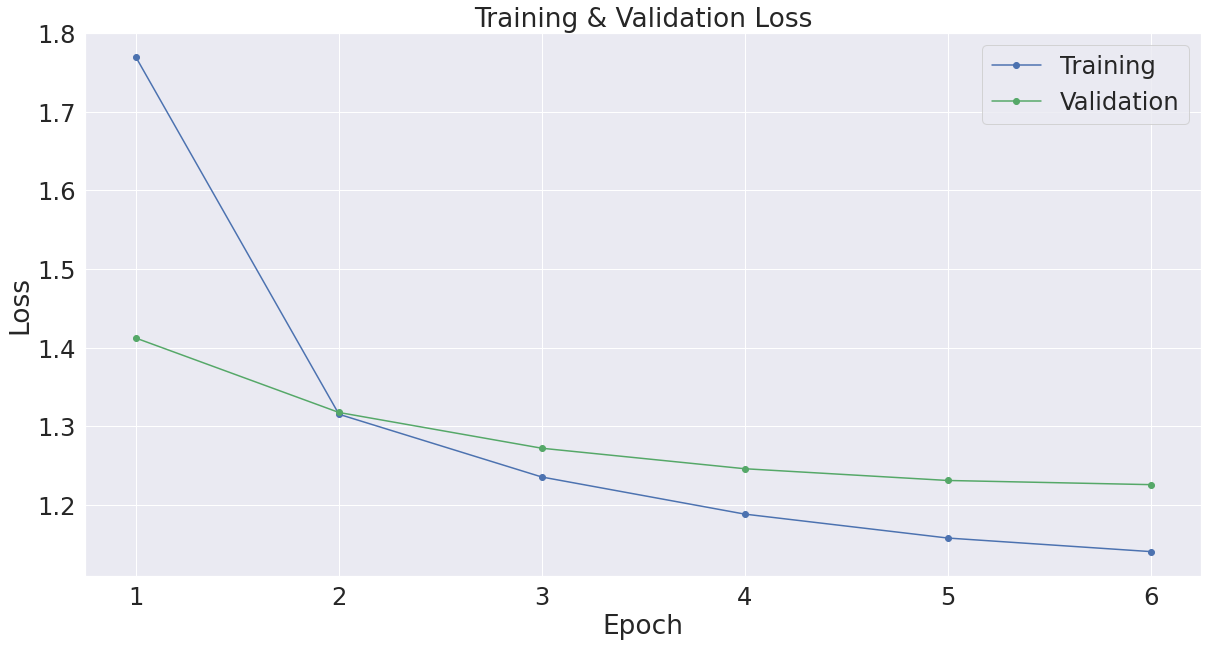

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')

sns.set(font_scale=2.2)
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
xt = [i for i in range(1,epochs+1)]
plt.xticks(xt)

plt.show()

## Test model

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import random
try:
  from transformers import GPTNeoForCausalLM, GPTNeoConfig
except:
  !pip install transformers
  from transformers import GPTNeoForCausalLM, GPTNeoConfig
import numpy as np
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.9 MB/s 
     |████████████████████████████████| 101 kB 14.4 MB/s 
     |████████████████████████████████| 6.6 MB 62.0 MB/s 
     |████████████████████████████████| 596 kB 66.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
configuration = GPTNeoConfig("EleutherAI/gpt-neo-125M", output_hidden_states=False)

In [4]:
configuration

GPTNeoConfig {
  "activation_function": "gelu_new",
  "attention_dropout": 0.0,
  "attention_layers": [
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local",
    "global",
    "local"
  ],
  "attention_types": [
    [
      [
        "global",
        "local"
      ],
      12
    ]
  ],
  "bos_token_id": 50256,
  "embed_dropout": 0.0,
  "eos_token_id": 50256,
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": null,
  "layer_norm_epsilon": 1e-05,
  "max_position_embeddings": 2048,
  "model_type": "gpt_neo",
  "num_heads": 16,
  "num_layers": 24,
  "resid_dropout": 0.0,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  

In [5]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|sos|>', 
                                          eos_token='<|eos|>', 
                                          pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
configuration

In [6]:
model = GPTNeoForCausalLM.from_pretrained("/content/gdrive/MyDrive/gpt-neo/modelKey_lr34_b4_e5")#, config=configuration)

In [7]:
#config = GPT2LMHeadModel('configuration')
model = GPTNeoForCausalLM.from_pretrained("/content/gdrive/MyDrive/gpt-neo/modelKey_lr34_b4_e5")#, config=configuration)

model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-Neo model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:-2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
model.cuda()

In [8]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 179 µs (started: 2022-08-10 14:18:50 +00:00)


In [10]:

max_text = 677

time: 2.7 ms (started: 2022-08-10 14:20:31 +00:00)


In [17]:
model.eval()

prompt = "<|sos|> Forester Cover Letter, keywords: planting new trees, monitoring, conserving wildlife habitats\n"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = max_text,
                                temperature=0.7,
                                top_p=0.95, 
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
    example = tokenizer.decode(sample_output, skip_special_tokens=True)
    print("{}:{}\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
    

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Forester Cover Letter, keywords: planting new trees, monitoring, conserving wildlife habitats
As an experienced volunteer and a leader with experience advising your planting operations to the planting manager, I am certain to make a significant impact on your planting operation as your planting manager. My expertise in planting operations has allowed me to make a significant contribution to your planting team.
My experience includes coordinating planting operations, monitoring plant growth, and managing planting situations. My strong communication, positive attitude, and the ability to quickly adapt to new planting situations have encouraged me to use my skills and my talents to help grow the best plants available.
Consider the following highlights of my qualifications:
 Successfully managing planting situations—including planting operations, planting inspections, and planting surveys—give me confidence in my ability to make a significant contribution to your planting operation.
 Ex

In [ ]:
example

' Social Worker Cover Letter, keywords: enduring, flexible, reliable\nI am submitting my resume for your review. With my experience and background, I am confident that I would be an immediate asset to your company.\nMy expertise lies in providing critical social support services to vulnerable and/or marginalized individuals. With this background, I have a solid background in providing critical social services to individuals afflicted with mental and/or physical disabilities. My demonstrated success in providing critical social support to individuals and families of all ages, disabilities, and backgrounds has resulted in a significant increase in the number of social workers being called to perform these services.\nConsider the following highlights of my qualifications:\n Able to perform daily tasks and maintain a healthy level of communication and focus with clients as a Social Worker for the past 14 years.\n With a proven track record of providing critical social services to individua

time: 3.64 ms (started: 2022-08-08 12:11:51 +00:00)


In [ ]:
len(torch.tensor(tokenizer.encode(example)).unsqueeze(0)[0])/6.84

35.526315789473685

time: 32 ms (started: 2022-08-08 12:11:58 +00:00)


## Quantitative Evaluation of the Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install SoMaJo==2.2.0
from somajo import SoMaJo
def detokenize(tokens):
    out = []
    for token in tokens:
        if token.original_spelling is not None:
            out.append(token.original_spelling)
        else:
            out.append(token.text)
        if token.space_after:
            out.append(" ")
    return "".join(out)

def splitTextIntoSentences(text, number_sentences=5):
    tokenizer = SoMaJo("de_CMC")
    sentences = tokenizer.tokenize_text([text])
    sentence_decoded = []
    for sentence in tqdm(sentences):
        sentence_decoded.append(detokenize(sentence))
    return sentence_decoded #[:number_sentences]
    #return nltk.sent_tokenize(text, language=language)[:number_sentences]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import textstat

In [ ]:
import pandas as pd

In [ ]:
!pip install --quiet datasets
!pip install --quiet bert_score
!pip install --quiet rouge_score
!pip install --quiet bleu
!pip install --quiet bleurt
!pip install --quiet google_bleu

ERROR: Could not find a version that satisfies the requirement google_bleu (from versions: none)
ERROR: No matching distribution found for google_bleu


In [ ]:
pip install git+https://github.com/google-research/bleurt.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-dglc9228
  Running command git clone -q https://github.com/google-research/bleurt.git /tmp/pip-req-build-dglc9228


In [ ]:
from datasets import list_metrics
metrics_list = list_metrics()
print(metrics_list)

['accuracy', 'bertscore', 'bleu', 'bleurt', 'cer', 'chrf', 'code_eval', 'comet', 'competition_math', 'coval', 'cuad', 'exact_match', 'f1', 'frugalscore', 'glue', 'google_bleu', 'indic_glue', 'mae', 'mahalanobis', 'matthews_correlation', 'mauve', 'mean_iou', 'meteor', 'mse', 'pearsonr', 'perplexity', 'poseval', 'precision', 'recall', 'rl_reliability', 'roc_auc', 'rouge', 'sacrebleu', 'sari', 'seqeval', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'ter', 'trec_eval', 'wer', 'wiki_split', 'xnli', 'xtreme_s', 'Vlasta/pr_auc', 'abdusahmbzuai/aradiawer', 'angelina-wang/directional_bias_amplification', 'codeparrot/apps_metric', 'cpllab/syntaxgym', 'daiyizheng/valid', 'erntkn/dice_coefficient', 'gorkaartola/my_metric', 'hack/test_metric', 'jordyvl/ece', 'kaggle/ai4code', 'kaggle/amex', 'loubnabnl/apps_metric2', 'lvwerra/bary_score', 'lvwerra/test', 'mathemakitten/harness_sentiment', 'mathemakitten/sentiment', 'mfumanelli/geometric_mean', 'mgfrantz/roc_auc_macro', 'yzha/ctc_eval']


In [ ]:
from datasets import load_metric
from datasets import load
bert_metric = load_metric('bertscore')
rouge_metric = load_metric('rouge')
bleu_metric = load_metric('bleu')
bleurt_metric = load_metric('bleurt')
google_bleu_metric = load_metric('google_bleu')

INFO:tensorflow:Reading checkpoint /root/.cache/huggingface/metrics/bleurt/default/downloads/extracted/887f2dc36c17f53c287f696681b8f7c947278407c1cf9f226662e16c8c0dc417/bleurt-base-128.


INFO:tensorflow:Reading checkpoint /root/.cache/huggingface/metrics/bleurt/default/downloads/extracted/887f2dc36c17f53c287f696681b8f7c947278407c1cf9f226662e16c8c0dc417/bleurt-base-128.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


In [ ]:
from transformers import pipeline
cola_classifier = pipeline(model="textattack/bert-base-uncased-CoLA")

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

In [ ]:
test_data = pd.read_csv('/content/gdrive/MyDrive/gpt2/dataset/clean_test_key_field_cover_letters.csv')

In [ ]:
test_data

,Unnamed: 0,fields,keywords,text
0,0,Account Executive Cover Letter,"formidable, polished, hard, knowledgeable, fri...",It is a pleasure to be applying for the Accoun...
1,1,Account Manager Cover Letter,"pitch, vertical, pharmaceutical, prestigious, ...",I'm excited to be applying for the Account Man...
2,2,Accounts Payable Cover Letter,"very, pristine, valid, meticulous, organized",I would like to introduce myself as a candidat...
3,3,Adjunct Faculty Cover Letter,"sterling, diligent, mathematical, inspiring, c...",I'm honored to apply to the Adjunct Faculty po...
4,4,Administrative Assistant Cover Letter,"chronic, thrilled, electronic, compassionate, ...",I am thrilled to put my name in for the Admini...
...,...,...,...,...
95,95,Therapist Cover Letter,"curious, gifted, pharmacological, empathetic, ...",I am pleased to apply for the position of ther...
96,96,Training Specialist Cover Letter,"blended, accessible, bilingual, quick, outgoing",I am writing to express my interest in the Tra...
97,97,Travel Agent Cover Letter,"prolonged, former, less, grateful, short",I am submitting to you my application for the ...
98,98,Tutor Cover Letter,"retired, worth, correct, useful, extra",I'm excited to be applying as a Tutor at Centu...


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
model.eval()
bleu_scores, rouge_scores, bert_scores, bleurt_scores, cola_scores = [], [], [], [], []
generated_text = []
for idx, field in enumerate(tqdm(test_data['fields'])):

  prompt = "<|sos|>" + field+ ', keywords: '.join(test_data['keywords'][idx].split(', ')[:3])+"\n" 
  target_text = test_data.loc[idx]['text']
  target_sents = splitTextIntoSentences(target_text)

  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
  generated = generated.to(device)

  sample_outputs = model.generate(
                                  generated, 
                                  do_sample=True,   
                                  top_k=50, 
                                  max_length = max_text,
                                  temperature=0.7,
                                  top_p=0.95, 
                                  num_return_sequences=1
                                  )
  current_bleu, current_rouge, current_bert,  current_bleurt, cola = [], [], [], [], []
  for i, sample_output in enumerate(sample_outputs):
      #print("{}:{}\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
      sents = tokenizer.decode(sample_output, skip_special_tokens=True)

      sents = '\n'.join(sents.split('\n')[1:])
      generated_text.append(sents)
      print(sents)
      split_sents = splitTextIntoSentences(sents)
      #print(len(split_sents), len(target_sents))
      if len(split_sents) > len(target_sents):
        pad_length = len(split_sents) - len(target_sents)
        target_sents = target_sents + ['PADDING_SENT']*pad_length

      elif len(split_sents) < len(target_sents):
        pad_length = len(target_sents) - len(split_sents)
        split_sents = split_sents + ['PADDING_SENT']*pad_length
      #print(len(split_sents), len(target_sents))
      for j,sent in enumerate(split_sents):
          
          lookahead = 2
          if len(split_sents) - j < lookahead:
            lookahead = 1

          current_bleurt.append(bleurt_metric.compute(predictions = [sent],references = [target_sents[j:j+lookahead]])['scores'][0])
  

          bleu_input = [se.split() for se in target_sents[j:j+lookahead]]

          current_bleu.append(bleu_metric.compute(predictions=[sent.split()], references=[bleu_input])['precisions'][0])


          current_rouge.append(rouge_metric.compute(predictions=[sent],references=[target_sents[j:j+lookahead]])['rouge1'][0][1])
          
          
          current_bert.append(bert_metric.compute(predictions=[sent],references=[target_sents[j:j+lookahead]],lang='en')['precision'][0])

          cola.append(cola_classifier(sent))
          print(cola[j])
  cola_scores.append(cola)

  bleu_scores.append(current_bleu)
  bleurt_scores.append(current_bleurt)
  rouge_scores.append(current_rouge)
  bert_scores.append(current_bert)


    

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing you to express my interest in the advertised position of Account Executive at Wildfire Industries. I am a highly organized and detail oriented professional with six years of experience in accounting and finance. My professional goals have always been to create and lead high-performance teams, and to work hard to meet or exceed those goals. I am a hard worker and I take pride in being able to pitch in and contribute to every company's problems.
During my previous role as Account Executive at Blaine Community Solutions, I was tasked with developing and implementing strategic solutions to drive operations and profitability. I was responsible for developing and instituting new policies, procedures and controls designed to maximize Account Executive success. This resulted in a drastic reduction of expenses for the company, and I was able to streamline accounting and finance functions to improve efficiency and productivity.
My professional highlights range from:
 Developing and 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9681882858276367}]
[{'label': 'LABEL_1', 'score': 0.9714332818984985}]
[{'label': 'LABEL_1', 'score': 0.9779796600341797}]
[{'label': 'LABEL_1', 'score': 0.9728220701217651}]
[{'label': 'LABEL_1', 'score': 0.9725415110588074}]
[{'label': 'LABEL_1', 'score': 0.9787825345993042}]
[{'label': 'LABEL_1', 'score': 0.9768739342689514}]
[{'label': 'LABEL_1', 'score': 0.9474291801452637}]
[{'label': 'LABEL_1', 'score': 0.9596561789512634}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing you to submit my resume for the open position of Account Manager at medina pharmaceutical. I am a high-performing professional with 14 years of experience managing accounts for top- pharmaceutical companies. I am a vertical with a talent for seeing through all the different software programs that each company has available. I am skilled at building and managing high volumes of records, and I am the best person to tell the company that I am the best.
I am a graduate from my first year of Pharmaceutical University, and I am happy to apply my skills and experience to the role of Account Manager. I am currently hiring for a position in a customer-facing position, which I think is a great position for.
My professional experience includes 20 years of management of pharmaceutical accounts for high-level executives. I am an extremely fast-paced individual who needs to be able to motivate others to work on their accounts. I have worked in the financial sector, and I think I would m

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9531192183494568}]
[{'label': 'LABEL_1', 'score': 0.9777658581733704}]
[{'label': 'LABEL_1', 'score': 0.8753539323806763}]
[{'label': 'LABEL_1', 'score': 0.9708784222602844}]
[{'label': 'LABEL_1', 'score': 0.9792544841766357}]
[{'label': 'LABEL_1', 'score': 0.6002509593963623}]
[{'label': 'LABEL_1', 'score': 0.972053050994873}]
[{'label': 'LABEL_1', 'score': 0.9669690132141113}]
[{'label': 'LABEL_1', 'score': 0.9713721871376038}]
[{'label': 'LABEL_1', 'score': 0.9762884378433228}]
[{'label': 'LABEL_1', 'score': 0.9796136617660522}]
[{'label': 'LABEL_1', 'score': 0.9444813132286072}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to express my interest in the advertised position of Account Manager at River Tech. As a highly skilled and driven professional, I feel I have the knowledge and experience to allow me to contribute toward the success of your company.
My professional experience includes overseeing accounting and payroll functions for a large company. I have a strong track record of successfully identifying and resolving payroll conflicts, maintaining and hiring new staff, and consistently completing all payroll functions within high-pressure environments.
Here are some highlights of my qualifications and experience:
 Implemented and maintained an improved and growing department comprising more than 70 employees.
 Created and led payroll and compensation procedures, including best practices.
 Ensured comprehensive compliance with all federal and state regulations.
My expertise in all accounting and payroll functions is proven, and I am confident I can contribute toward the success of River T

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9802042841911316}]
[{'label': 'LABEL_1', 'score': 0.9673382043838501}]
[{'label': 'LABEL_1', 'score': 0.9763746857643127}]
[{'label': 'LABEL_1', 'score': 0.9668985605239868}]
[{'label': 'LABEL_1', 'score': 0.9542824029922485}]
[{'label': 'LABEL_1', 'score': 0.9157048463821411}]
[{'label': 'LABEL_1', 'score': 0.9396264553070068}]
[{'label': 'LABEL_1', 'score': 0.9790799021720886}]
[{'label': 'LABEL_1', 'score': 0.9789142608642578}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to apply for the open position of adjunct supervisor at the New York Community Coalition. I have three years of experience in customer service and support and I believe I have the skills you are looking for in an Adjunct supervisor. I am committed to helping people and working with others to make their busy day even more productive.
My professional accomplishments include successfully promoting and securing new customers, maintaining inventory levels, and increasing the company’s overall quality of life. I am diligent, detail-oriented, and a person who always gets the job done right the first time. I pride myself on being a positive and diligent leader and on staying diligent in the knowledge that I can meet and exceed those expectations.
Here are some career highlights and qualifications that make a qualified addition to the team:
 Led an inventory control team in achieving a 28% reduction in inventory from 2004-2006
 Increased company’s overall quality of life through ef

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9557906985282898}]
[{'label': 'LABEL_1', 'score': 0.9555531144142151}]
[{'label': 'LABEL_1', 'score': 0.9596918821334839}]
[{'label': 'LABEL_1', 'score': 0.9741659164428711}]
[{'label': 'LABEL_1', 'score': 0.975426435470581}]
[{'label': 'LABEL_1', 'score': 0.9768185615539551}]
[{'label': 'LABEL_1', 'score': 0.937154233455658}]
[{'label': 'LABEL_1', 'score': 0.9588873386383057}]
[{'label': 'LABEL_1', 'score': 0.9697362184524536}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm thrilled to be applying for the Administrative Assistant position at River Tech. I'm excited to be applying for the position of Administrative Specialist with your company. River Tech is a fast-paced, customer-centric firm with a unique focus on data management and information systems integration. I thrive on meeting and surpassing customer expectations and requirements and am thrilled to be applying for the role.During my time at Innovation Advertising, I thrived on being able to analyze and solve complex problems and efficiently manage all aspects of data. I was recognized for being the first person to create a new data management plan that had a plan of action. I was also recognized for being the first to implement an automated data entry system that saved the company money and time. I have worked in the retail sector for the past five years, and I have managed customer data and managed billing functions for the past four. I also excel at working with both digital and traditiona

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.98366779088974}]
[{'label': 'LABEL_1', 'score': 0.9779618978500366}]
[{'label': 'LABEL_1', 'score': 0.9620030522346497}]
[{'label': 'LABEL_1', 'score': 0.9693393111228943}]
[{'label': 'LABEL_1', 'score': 0.9561193585395813}]
[{'label': 'LABEL_1', 'score': 0.9745528697967529}]
[{'label': 'LABEL_1', 'score': 0.9660273790359497}]
[{'label': 'LABEL_1', 'score': 0.978766918182373}]
[{'label': 'LABEL_1', 'score': 0.9760115146636963}]
[{'label': 'LABEL_1', 'score': 0.979539155960083}]
[{'label': 'LABEL_1', 'score': 0.9208191633224487}]
[{'label': 'LABEL_1', 'score': 0.9793972373008728}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.7858203053474426}]
[{'label': 'LABEL_1', 'score': 0.9561988115310669}]
[{'label': 'LABEL_1', 'score': 0.7751059532165527}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am excited to be applying for the open user role at Lysix Technologies. I am thrilled that I am able to use the widgets, metrics and analytics provided by Lysix Technologies to make a positive and dynamic impact on the operations and functions of Lysix Technologies.
 Lysix Technologies is a highly efficient and well-regarded data visualization and marketing company. I have extensive experience with the usage of widgets and data visualization tools, and I am confident that I >possess the skills</a> necessary to be a great asset to your organization.
 I am an enthusiastic and motivated individual who has the drive and the the experience to thrive under pressure. I have successfully demonstrated my abilities in promotional campaigns, web development and team-oriented environments. I have also successfully implemented analytics to improve the quality of the data visualizations.
 Thank you for reading this review. I look forward to speaking with you soon.
Sincerely,


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9791152477264404}]
[{'label': 'LABEL_1', 'score': 0.9698151350021362}]
[{'label': 'LABEL_1', 'score': 0.9531168341636658}]
[{'label': 'LABEL_1', 'score': 0.9530266523361206}]
[{'label': 'LABEL_1', 'score': 0.9594542980194092}]
[{'label': 'LABEL_1', 'score': 0.9737508893013}]
[{'label': 'LABEL_1', 'score': 0.9706289172172546}]
[{'label': 'LABEL_1', 'score': 0.9509298801422119}]
[{'label': 'LABEL_1', 'score': 0.977471113204956}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am applying for the Admissions Counselor position at Innovation Advertising. I have a bachelor’s degree in admissions and three years of experience working for Fortune 500 companies. I think my experience, if given the opportunity, will make a positive contribution to the Innovation Advertising segment.
I have worked in a variety of admissions departments, including financial aid, admissions, and payroll. I think my experience in this position, coupled with my education and experience in the admissions business, will help me excel at Innovation Advertising.
My resume is enclosed for your review. I thank you for your time and interest. I look forward to speaking with you soon.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9735271334648132}]
[{'label': 'LABEL_1', 'score': 0.9709004163742065}]
[{'label': 'LABEL_1', 'score': 0.9602742195129395}]
[{'label': 'LABEL_1', 'score': 0.9737861752510071}]
[{'label': 'LABEL_1', 'score': 0.9746060967445374}]
[{'label': 'LABEL_1', 'score': 0.9758726358413696}]
[{'label': 'LABEL_1', 'score': 0.9579759240150452}]
[{'label': 'LABEL_1', 'score': 0.977471113204956}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I recently learned of your need for a new Art Teacher at St. Helena University, and I have been inspired to submit my resume for review. I have a Bachelor’s degree in Art and two years of experience teaching classes at Foundry Art College. I am excited about working with you and think you will find my experience and education to be a benefit to your school.
My professional experience includes working with children from a wide range of backgrounds. I am currently pursuing my Art Teacher’s degree at St. Helena University and am currently working under the supervision of your current Art Teacher. I am also very familiar with the age


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9790312647819519}]
[{'label': 'LABEL_1', 'score': 0.9740652441978455}]
[{'label': 'LABEL_1', 'score': 0.9702672958374023}]
[{'label': 'LABEL_1', 'score': 0.9813319444656372}]
[{'label': 'LABEL_1', 'score': 0.9702227711677551}]
[{'label': 'LABEL_1', 'score': 0.8343420028686523}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': '

0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Throughout the course of my educational experience as an artist and story leader for color-coded storyboards and photo galleries, I have been fascinated by the world outside of my school of color. I believe my education excites my art as well, as I would be a valuable asset to the community of River Bend.
During my academic studies, I worked as an art student at Longford Tech, which specialized in using advanced math and science terminology to express ideas. I was in charge of the project, and I collaborated with various people to design a interactive art class to educate them on the meaning of the word "berman" used by the art students. This technique allowed us to code several ideas into something more than just art, but also to create a range of visual designs for the art class.
My experience as a artist and story leader has prepared me to be an asset to the team at River Bend, and I am ready to use my skills to the best benefit of my abilities. Thank you for taking the time to revi

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9551623463630676}]
[{'label': 'LABEL_1', 'score': 0.9583333134651184}]
[{'label': 'LABEL_1', 'score': 0.9818615913391113}]
[{'label': 'LABEL_1', 'score': 0.979212760925293}]
[{'label': 'LABEL_1', 'score': 0.9594857096672058}]
[{'label': 'LABEL_1', 'score': 0.9728182554244995}]
[{'label': 'LABEL_1', 'score': 0.8946329355239868}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have spent the past two years as a Principal at Ridgemont High School in New York City, teaching English as Second Language for the last three years. I have a strong background in this industry, and I think I am the ideal candidate for the position.
My education was in the state middle schools, and there, I had the opportunity to work as a part of the college-based learning program, which was very successful. In the classroom, I have a lot of hands-on projects to think about, and I have a strong focus on English as Second Language.
I also have experience with a business-based learning program, and I have experience with a complementary group of students, and I have experience with a whole school program.
I would love to meet with you in person and talk more about the position. Thank you for taking the time to consider my application.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9797693490982056}]
[{'label': 'LABEL_1', 'score': 0.9783071279525757}]
[{'label': 'LABEL_1', 'score': 0.9766820669174194}]
[{'label': 'LABEL_1', 'score': 0.9702248573303223}]
[{'label': 'LABEL_1', 'score': 0.9638630151748657}]
[{'label': 'LABEL_1', 'score': 0.9736779928207397}]
[{'label': 'LABEL_1', 'score': 0.9687280058860779}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


When I learned of your need for a new BLS, I hastened to submit my resume for your review. With my experience in financial support with the City of Boulder—along with my superior interpersonal and leadership talents—I am confident in my ability to significantly benefit your team in this capacity.
From communicating with customers and identifying their needs to processing payments and ensuring quality assurance, my background has prepared me to excel in this role. With three years of experience in customer-facing positions with the City of Denver, I am confident that my additional strengths in information management, team collaboration, and empathic communication will readily translate to this position.
Highlights of my background include:
 Demonstrating unparalleled dedication to providing vital support to the city of Denver in providing vital customer service and ensuring top-flight quality of service.
 Performing day-to-day operational duties including inventory control, purchasing, 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9743084907531738}]
[{'label': 'LABEL_1', 'score': 0.9470353722572327}]
[{'label': 'LABEL_1', 'score': 0.9569970965385437}]
[{'label': 'LABEL_1', 'score': 0.95858234167099}]
[{'label': 'LABEL_1', 'score': 0.9275333881378174}]
[{'label': 'LABEL_1', 'score': 0.9605016112327576}]
[{'label': 'LABEL_1', 'score': 0.9221508502960205}]
[{'label': 'LABEL_1', 'score': 0.942997395992279}]
[{'label': 'LABEL_1', 'score': 0.9598066210746765}]
[{'label': 'LABEL_1', 'score': 0.9827482104301453}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have loved eating, healthy, and activity-related food for years now, and I am writing to make a point in this food-focused food-service sector. I believe I am a perfect fit for your Barista position because I am the ideal person to make your team’s day.
My work history started as part of my education at Ridgemont Community College. My Bachelor’s degree in Health and Wellness six years later covered the same basic ingredients as my regular education, which involved taking overarching courses in the field. My regular education experience includes reading and writing and working as part of a team, and I am excited about the opportunity to use my skills to help your company become a healthy and stress-free activity for its employees.
My best experience so far as a Barista has been consistent, innovative, and positive. My attention to detail and attention to detail-based skills are what keep me positive and motivated in this fast-paced and customer-facing environment. I am able to thrive 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9539839625358582}]
[{'label': 'LABEL_1', 'score': 0.96275395154953}]
[{'label': 'LABEL_1', 'score': 0.9736666083335876}]
[{'label': 'LABEL_1', 'score': 0.9676326513290405}]
[{'label': 'LABEL_1', 'score': 0.9748355150222778}]
[{'label': 'LABEL_1', 'score': 0.8858739733695984}]
[{'label': 'LABEL_1', 'score': 0.9706994295120239}]
[{'label': 'LABEL_1', 'score': 0.9461996555328369}]
[{'label': 'LABEL_1', 'score': 0.9722400903701782}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9742386937141418}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to apply for the position of a your customer bookkeeper. I have a Bachelor’s degree in web design and two years of experience in Customer Service where I would love to join a company where I could contribute my skills and knowledge while ensuring all customer needs are met.
My professional experience includes reviewing and installing databases, creating user-friendly codes, and working with fellow staff to code a user-friendly interface for my product. I am proficient in all of the areas of Customer Service provided in this position and all the other areas of the job including coding support for multiple projects.
I am confident that my experience and my unique set of skills will make me an asset to your team. Thank you for your consideration, I look forward to speaking with you soon.Sincerely,John Finch, M got my Bachelor’s degree in web design from Texas State University. During my three years of experience as a customer service specialist, I have been able to help users

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.7275295853614807}]
[{'label': 'LABEL_1', 'score': 0.9613869786262512}]
[{'label': 'LABEL_1', 'score': 0.9804058074951172}]
[{'label': 'LABEL_1', 'score': 0.8659654259681702}]
[{'label': 'LABEL_1', 'score': 0.9761231541633606}]
[{'label': 'LABEL_1', 'score': 0.9635762572288513}]
[{'label': 'LABEL_1', 'score': 0.9671095013618469}]
[{'label': 'LABEL_1', 'score': 0.9425999522209167}]
[{'label': 'LABEL_1', 'score': 0.9755870699882507}]
[{'label': 'LABEL_1', 'score': 0.9684514403343201}]
[{'label': 'LABEL_1', 'score': 0.9671095013618469}]
[{'label': 'LABEL_1', 'score': 0.9425999522209167}]
[{'label': 'LABEL_1', 'score': 0.9755870699882507}]
[{'label': 'LABEL_1', 'score': 0.9214341044425964}]
[{'label': 'LABEL_1', 'score': 0.9635809063911438}]
[{'label': 'LABEL_1', 'score': 0.9692949652671814}]
[{'label': 'LABEL_1', 'score': 0.9761917591094971}]
[{'label': 'LABEL_1', 'score': 0.9783468246459961}]
[{'label': 'LABEL_1', 'score': 0.9707664251327515}]
[{'label': '

0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to apply for the position of Brand Manager at Retail Ocean. As a highly qualified and accomplished professional, I possess the skills and knowledge necessary to determine whether a brand is meeting your requirements for the position.
I have been awarded the Brand Management Branding Management Award in 2013 and 2014 for superior performance and product quality. My work style focuses on key promotional initiatives, which have provided me with tips for where to put my creativity and product knowledge. I am currently pursuing a Bachelor’s degree in Marketing and Advertising from the University of California at Berkeley.
I am a self-starter and excel at managing brand orders, clearly explaining the importance of each and every line of product to customers. I am also deeply familiar with the proper go-to sources of information for companies such as TechNOW.com and The Foundry Marketing Group. Enclosed is my resume, and I hope to hear from you soon. Thank you for your time and c

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9421043992042542}]
[{'label': 'LABEL_1', 'score': 0.9630075097084045}]
[{'label': 'LABEL_1', 'score': 0.960468590259552}]
[{'label': 'LABEL_1', 'score': 0.954422116279602}]
[{'label': 'LABEL_1', 'score': 0.971614420413971}]
[{'label': 'LABEL_1', 'score': 0.9735106825828552}]
[{'label': 'LABEL_1', 'score': 0.9584958553314209}]
[{'label': 'LABEL_1', 'score': 0.9718434810638428}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am a student at the University of Nantucket, in my last year of high school. I want to express my interest in the busser position at the university. I know that I would have the perfect opportunity to work with your company to work this position for them.
My professional experience includes making money by working as a waiter and busser at a restaurant. I also have experience working as an administrative assistant and a member of the crew at a restaurant.
Here are some of my most relevant qualifications and accomplishments.
 Earned Bachelor’s degree in Accounting from the University of Nantucket
 Worked as busser at a restaurant
 Earned Master’s degree in Finance from the University of Nantucket
My videos about bussers and concub Playoffs why I would be a good addition to your organization
I am a student at the University of Nantucket, in my last year of high school. I want to express my interest in the busser position.I know that I would have theperfect opportunity to work as a buss

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9764612913131714}]
[{'label': 'LABEL_1', 'score': 0.9876685738563538}]
[{'label': 'LABEL_1', 'score': 0.9532805681228638}]
[{'label': 'LABEL_1', 'score': 0.9825029373168945}]
[{'label': 'LABEL_1', 'score': 0.9639294743537903}]
[{'label': 'LABEL_1', 'score': 0.9728236794471741}]
[{'label': 'LABEL_1', 'score': 0.6924901008605957}]
[{'label': 'LABEL_1', 'score': 0.9883792400360107}]
[{'label': 'LABEL_1', 'score': 0.9452719688415527}]
[{'label': 'LABEL_1', 'score': 0.9825029373168945}]
[{'label': 'LABEL_1', 'score': 0.9655848145484924}]
[{'label': 'LABEL_1', 'score': 0.963655412197113}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


When I saw your job posting for an open position with the National Association of Health Care Staffors, I knew it was the perfect opportunity for me to call and ask if there were any people in their community who I could trust to make an immediate and positive impact on my clients’overall health. I am confident that my background and my ability to quickly connect with potential customers will make me a great asset to your team.
After working for four years as a clerk with one of the most reputable and reputable organizations in the community, my experience has prepared me to make a positive and lasting contribution to your organization. My additional strengths in customer service, support, and conflict resolution are certain to render me an asset to your team.
I invite you to consider the following highlights of my qualifications:
 More than six years of experience in customer support as a nurse/health care assistant, and that includes the role of clerk and member of your staff.
 Becam

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9187045097351074}]
[{'label': 'LABEL_1', 'score': 0.9740318655967712}]
[{'label': 'LABEL_1', 'score': 0.9606184959411621}]
[{'label': 'LABEL_1', 'score': 0.9631930589675903}]
[{'label': 'LABEL_1', 'score': 0.951887309551239}]
[{'label': 'LABEL_1', 'score': 0.9609451293945312}]
[{'label': 'LABEL_0', 'score': 0.9030091166496277}]
[{'label': 'LABEL_1', 'score': 0.9459993839263916}]
[{'label': 'LABEL_1', 'score': 0.9078016877174377}]
[{'label': 'LABEL_1', 'score': 0.9712146520614624}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing in regard to becoming a cashier at your firm. With my Masters degree in finance, I have learned how to work as a cashier in a busy hospital setting. My other accomplishments include working as a cashier in two offices and a bakery. I also have experience in managing cashier responsibilities in a busy hospital setting, such as operating accounts, cashier assignments, and paperwork.
In my previous position at Centurion Medical, I worked as a cashier in two offices. I was responsible for creating and maintaining cash register materials and databases. I was also tasked with tracking down specific hospital staff, ordering supplies, and preparing insurance policies and renewals.
I believe my experience in cashier responsibilities is what makes me a good fit for your firm. I would enjoy meeting with you to discuss my qualifications and experience in this field. Please allow me to thank you for your time and consideration.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9546665549278259}]
[{'label': 'LABEL_1', 'score': 0.9655383825302124}]
[{'label': 'LABEL_1', 'score': 0.964112401008606}]
[{'label': 'LABEL_1', 'score': 0.9718070030212402}]
[{'label': 'LABEL_1', 'score': 0.9758533239364624}]
[{'label': 'LABEL_1', 'score': 0.9790037274360657}]
[{'label': 'LABEL_1', 'score': 0.9756447076797485}]
[{'label': 'LABEL_1', 'score': 0.9700776934623718}]
[{'label': 'LABEL_1', 'score': 0.9720997214317322}]
[{'label': 'LABEL_1', 'score': 0.9695286154747009}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have worked as a 
 for over six years now and have developed many strategies that I believe will be an asset to your company as your next executive. I am a well-educated minder, and I believe effective sales and marketing strategies are essential to the success of a company.
My professional experience includes writing sales reports, analyzing market trends and researching market conditions and then creating and presenting the designed presentations for a general sales representative. I have been publicly recognized twice for having a positive impact on the growth of sales of various brands in the markets of the internet and for having a positive and positive attitude on all marketing campaigns.
Below are some highlights of my experience and qualifications:
 Developed and presented marketing presentations to vendors
 Evaluated market trends and fixed sales duties
 Conducted data collection and analysis
 Resolved issues and concerns regarding the administration of the company’s website

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9068630933761597}]
[{'label': 'LABEL_1', 'score': 0.9787276387214661}]
[{'label': 'LABEL_1', 'score': 0.9530507922172546}]
[{'label': 'LABEL_1', 'score': 0.9601223468780518}]
[{'label': 'LABEL_1', 'score': 0.9641444087028503}]
[{'label': 'LABEL_1', 'score': 0.9752540588378906}]
[{'label': 'LABEL_1', 'score': 0.9689850211143494}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am excited to apply for the Trainee role at your organization. I am a hard worker, and I love to do everything I can to make the most out of my experience. I have extensive experience in training and helping people to perform their assigned tasks. I enjoy working as part of a team and am an active member of the Trainee team.
My professional experience includes working in a variety of settings, such as schools, hospitals, and soccer practice. I am a self-starter and excel at organizing drills, making progress, and helping people learn everything they need to know. I have also worked in a variety of other areas, such as marketing, fundraising, and customer service.
I know I could bring challenges to your organization, and I would love to discuss my skills further in an interview. Thank you for your time and consideration.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.979235827922821}]
[{'label': 'LABEL_1', 'score': 0.9771142601966858}]
[{'label': 'LABEL_1', 'score': 0.9816568493843079}]
[{'label': 'LABEL_1', 'score': 0.9625989198684692}]
[{'label': 'LABEL_1', 'score': 0.9768434762954712}]
[{'label': 'LABEL_1', 'score': 0.9769982099533081}]
[{'label': 'LABEL_1', 'score': 0.9726969003677368}]
[{'label': 'LABEL_1', 'score': 0.9773019552230835}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing in response to your ad seeking an experienced civil engineer at GBI Group. As a fully trained Civil Engineer with a variety of training and hands-on skills, I would bring a service-focused, hard-working attitude to this position.
I have over 14 years of experience in civil engineering and have worked in various settings in various industries, including law, business, and manufacturing. I have worked in various positions over the past 14 years, and have learned that differentials in skill set and work ethic are just as important as goals.
As a Civil Engineer at GBI Group, I have been responsible for many facets of the civil sector. I have been recognized for my hard-working, fastidious approach to work, and my attention to detail. Also, I have over 8 years of experience in a collaborative environment that has led to significant increases in efficiency and productivity.
My qualifications include:
 Civil Engineering training in the state of Washington, obtaining a degree in C

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9492390751838684}]
[{'label': 'LABEL_1', 'score': 0.9636343717575073}]
[{'label': 'LABEL_1', 'score': 0.9681167602539062}]
[{'label': 'LABEL_1', 'score': 0.9770810008049011}]
[{'label': 'LABEL_1', 'score': 0.9583069682121277}]
[{'label': 'LABEL_1', 'score': 0.9794642925262451}]
[{'label': 'LABEL_1', 'score': 0.9543700218200684}]
[{'label': 'LABEL_1', 'score': 0.9644224047660828}]
[{'label': 'LABEL_1', 'score': 0.8960811495780945}]
[{'label': 'LABEL_1', 'score': 0.9273747205734253}]
[{'label': 'LABEL_1', 'score': 0.9472248554229736}]
[{'label': 'LABEL_1', 'score': 0.9626567363739014}]
[{'label': 'LABEL_1', 'score': 0.9733363389968872}]
[{'label': 'LABEL_1', 'score': 0.9743000864982605}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm excited to be applying for the CMA at Innovation University. I am very familiar with the coding skills you require, and I believe I can help your organization succeed. I also have experience in effectively managing projects, collaborating with other team members, and working on high-level teams.
My degree in computer science provided me with the foundation to pursue work in the field. I finished in top 25% of your organization at Innovation University with a course in business management costing less than $3,000 per year.
The job description you've highlighted for me is meant to be a great fit for the CMA position at Innovation University. I love working with people from all walks of life and derive great satisfaction from their participation in the coding process. I'm looking forward to the opportunity to be a part of your team.
I have a Bachelor's degree in computer science and have experience with varied coding courses. I've also completed a multiple course credit program at New

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9793924689292908}]
[{'label': 'LABEL_1', 'score': 0.9807197451591492}]
[{'label': 'LABEL_1', 'score': 0.9785065054893494}]
[{'label': 'LABEL_1', 'score': 0.9671611189842224}]
[{'label': 'LABEL_1', 'score': 0.7824169993400574}]
[{'label': 'LABEL_1', 'score': 0.9619866013526917}]
[{'label': 'LABEL_1', 'score': 0.9800106287002563}]
[{'label': 'LABEL_1', 'score': 0.9773228168487549}]
[{'label': 'LABEL_1', 'score': 0.9774518609046936}]
[{'label': 'LABEL_1', 'score': 0.9773373603820801}]
[{'label': 'LABEL_1', 'score': 0.9845700860023499}]
[{'label': 'LABEL_1', 'score': 0.9802399277687073}]
[{'label': 'LABEL_1', 'score': 0.9847692251205444}]
[{'label': 'LABEL_1', 'score': 0.9724284410476685}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am passionate about customer service and would like to be considered for the customer service position with your company. My background in customer support has given me the tools I need to help your company succeed.
I have worked in many customer service roles, from simple refocused service agents to highly skilled in this position. I have handled customer calls, reservations, and complaints as part of a large team. I worked with customers at a store and at aotiation sessions. After each appointment, I took it upon myself to detail my skills and my experience.
My experience is extensive, and I would be able to use what I've learned from my supervisors to help win their attention and give customers a superior experience. Thank you for considering my application and I hope my skills will prove valuable to you.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9750437140464783}]
[{'label': 'LABEL_1', 'score': 0.9805973172187805}]
[{'label': 'LABEL_1', 'score': 0.9555938243865967}]
[{'label': 'LABEL_1', 'score': 0.976722002029419}]
[{'label': 'LABEL_1', 'score': 0.963093638420105}]
[{'label': 'LABEL_1', 'score': 0.9707876443862915}]
[{'label': 'LABEL_1', 'score': 0.97380530834198}]
[{'label': 'LABEL_1', 'score': 0.9712576866149902}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing in response to your ad seeking an accomplished cosmetologist for your firm. As a highly accomplished and driven professional with more than 10 years of experience in providing comprehensive operational and administrative services to drive the success of high-level institutions, I stand in a prime position to significantly contribute to your objectives in this role.
My expertise lies in conducting in-depth research, designing and implementing technology programs, performing in-depth testing procedures, and collaborating with diverse teams to facilitate cosmetology efficiency and performance. Throughout my career, I have gained key experience in overseeing a wide variety of operational responsibilities to ensure optimal facility efficiency and patient satisfaction. My additional success in assessing user needs and requirements and developing efficient and productive procedures positions me to make a significant impact on your firm.
My qualifications include the following:
 P

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9608480334281921}]
[{'label': 'LABEL_1', 'score': 0.9383096098899841}]
[{'label': 'LABEL_1', 'score': 0.9734888672828674}]
[{'label': 'LABEL_1', 'score': 0.9667438864707947}]
[{'label': 'LABEL_1', 'score': 0.9670880436897278}]
[{'label': 'LABEL_1', 'score': 0.9575265645980835}]
[{'label': 'LABEL_1', 'score': 0.9379000663757324}]
[{'label': 'LABEL_1', 'score': 0.9511855244636536}]
[{'label': 'LABEL_1', 'score': 0.9572677612304688}]
[{'label': 'LABEL_1', 'score': 0.9712146520614624}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to express interest in the position of credit analyst with your firm. As a highly educated and driven professional with more than 10 years of experience in credit analysis and reporting, I am confident in my ability to contribute toward the success of your company.
I conducted in-depth research into credit and financial analyses for a wide variety of clients and situations. I discovered that most clients were looking for high-pressure analysis rooms and models while others were more interested in taking a risk or acting as a friend. I led more than a team of analysts on team-oriented projects and led teams on risk analysis while simultaneously providing the credit and service manager with effective and timely communication with clients.
I have proven myself as an asset to high-level teams in both independent and team-oriented environments. Key my expertise in risk analysis and management was to create an environment in which analysts and management teams would thrive. In t

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9672292470932007}]
[{'label': 'LABEL_1', 'score': 0.9672815203666687}]
[{'label': 'LABEL_1', 'score': 0.9775627851486206}]
[{'label': 'LABEL_1', 'score': 0.9786738753318787}]
[{'label': 'LABEL_1', 'score': 0.9370116591453552}]
[{'label': 'LABEL_1', 'score': 0.9794888496398926}]
[{'label': 'LABEL_1', 'score': 0.8708634376525879}]
[{'label': 'LABEL_1', 'score': 0.9707418084144592}]
[{'label': 'LABEL_1', 'score': 0.9883942604064941}]
[{'label': 'LABEL_1', 'score': 0.9244865775108337}]
[{'label': 'LABEL_1', 'score': 0.9700589179992676}]
[{'label': 'LABEL_1', 'score': 0.9795156121253967}]
[{'label': 'LABEL_1', 'score': 0.9652658104896545}]
[{'label': 'LABEL_1', 'score': 0.9259507060050964}]
[{'label': 'LABEL_1', 'score': 0.9690533876419067}]
[{'label': 'LABEL_1', 'score': 0.9715468883514404}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have been anolved in the application of critical thinking to the development of high quality customer service systems. I have developed my customer service skills to be an in-house key member of your service team. In my current position, I work as a lead for a customer service representative and they think my skills and experience are an asset to the company.
In my current position, I work for a company that is in its


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.8317916393280029}]
[{'label': 'LABEL_1', 'score': 0.9534370303153992}]
[{'label': 'LABEL_1', 'score': 0.9725000262260437}]
[{'label': 'LABEL_1', 'score': 0.7874728441238403}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to be considered for the position of data Entry by the Data Entry company that I have over the past several years. My extensive technical background in data entry and my ability to work in teams of varying sizes and abilities make me an ideal candidate for the position.
My professional experience includes designing and updating an extensive number of types of database entry systems and then working my way to the top of the product development team. I have over 12 years of experience in this field and have spent numerous years developing my entry skills in order to improve the quality of the work I had done.
Below are some of my achievements and qualifications that I feel clearly illustrate my ability to assume the role of data Entry by the Data Entry company:
 Earned a bachelor’s degree in computer science from Texas State University
 Prepared and installed a wide range of computer equipment and programs at multiple locations
 Prepared and installed a variety of computer t

0it [00:00, ?it/s]

[{'label': 'LABEL_0', 'score': 0.9002221822738647}]
[{'label': 'LABEL_1', 'score': 0.969521701335907}]
[{'label': 'LABEL_1', 'score': 0.9704681038856506}]
[{'label': 'LABEL_1', 'score': 0.9166123270988464}]
[{'label': 'LABEL_1', 'score': 0.930133581161499}]
[{'label': 'LABEL_1', 'score': 0.9688647985458374}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to apply for the position of database Analyst at Database Partners. I have a bachelor’s degree in computer science, two years of experience as a database analyst and three years of experience as a junior database analyst. During my two years at data-center where I work, I developed valuable skills in analyzing and managing large data sets while working independently and with little oversight.
Some of the skills you will get from my experience and my Bachelor’s degree are provided in this letter and the enclosed resume. I look forward to discussing these and other skills during an interview.
My background includes several years of experience as a database analyst at the Boston University facility, where I provided detailed help in organizing and streamlining database development. I also have experience working independently and with little oversight.
Some of the skills you will get from my experience and my Bachelor’s degree are provided in this letter and the enclosed resu

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.718550980091095}]
[{'label': 'LABEL_1', 'score': 0.9777829051017761}]
[{'label': 'LABEL_1', 'score': 0.9269171953201294}]
[{'label': 'LABEL_1', 'score': 0.9565194845199585}]
[{'label': 'LABEL_1', 'score': 0.9651018381118774}]
[{'label': 'LABEL_1', 'score': 0.974012553691864}]
[{'label': 'LABEL_1', 'score': 0.9770470261573792}]
[{'label': 'LABEL_1', 'score': 0.9565194845199585}]
[{'label': 'LABEL_1', 'score': 0.8886719346046448}]
[{'label': 'LABEL_1', 'score': 0.9811730980873108}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9742386937141418}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In my opinion, the job of a Dental Assistant is to provide a safe and pleasant environment where I can use my skills to improve and develop. I am a professional with 11 years of experience in this position.
Dental Assistant is my first experience in a dentistry position and I believe I have the experience to accomplish the above duties. I am also fully skilled in treating, detracting from, and assisting in every aspect of the Dental Assistant position. I am an observant, proficient, and reliable Dental Assistant.
I have provided the following highlights to date:
 Oversaw anesthesiologists and oral surgeons to deliver anesthetics and Dentistry services to a patient with a current diagnosis of Sub-Glandularoderma. Anesthesiologist A is responsible for delivering the instrumentation and medication to the patient and surgeons.
 Presided over by dentists that dentists should not use hand and power instruments in the office, dentists used a pen and booth system to utilize the power tools of 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9709484577178955}]
[{'label': 'LABEL_1', 'score': 0.955784261226654}]
[{'label': 'LABEL_1', 'score': 0.9182822108268738}]
[{'label': 'LABEL_1', 'score': 0.9570667743682861}]
[{'label': 'LABEL_1', 'score': 0.9849162101745605}]
[{'label': 'LABEL_1', 'score': 0.9117876887321472}]
[{'label': 'LABEL_1', 'score': 0.9023250341415405}]
[{'label': 'LABEL_1', 'score': 0.6921245455741882}]
[{'label': 'LABEL_1', 'score': 0.9590317010879517}]
[{'label': 'LABEL_1', 'score': 0.8211966156959534}]
[{'label': 'LABEL_1', 'score': 0.9741713404655457}]
[{'label': 'LABEL_1', 'score': 0.9823175668716431}]
[{'label': 'LABEL_1', 'score': 0.980445921421051}]
[{'label': 'LABEL_1', 'score': 0.9655263423919678}]
[{'label': 'LABEL_1', 'score': 0.9742386937141418}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to express my interest in becoming a Dental Hygienist at Innovation Dental. As a highly skilled and knowledgeable professional with more than seven years of experience Dental Hygienist experience in this role can contribute to the successful execution of a planned, results-focused Dental Right at the customer. I have been chosen by patients and staff members as a product of the Innovation Dental team to handle a full range of procedures and facilitate seamless treatment plans for a variety of patients.
I have worked in a full range of settings, including hospital settings, in a Dental Hygienist role for over five years. In this time, I have earned a reputation as a resourceful and goal-focused individual who is able to take charge of every aspect of the Dental Hygienist job. I have proven myself as a resourceful and goal-focused Dental Hygienist who is attentive to the needs of patients and able to take charge of every aspect of the job.
I am adept at taking charge of a wi

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9702438712120056}]
[{'label': 'LABEL_1', 'score': 0.5842841863632202}]
[{'label': 'LABEL_1', 'score': 0.9517442584037781}]
[{'label': 'LABEL_1', 'score': 0.9672161936759949}]
[{'label': 'LABEL_1', 'score': 0.9737460613250732}]
[{'label': 'LABEL_1', 'score': 0.9757153391838074}]
[{'label': 'LABEL_1', 'score': 0.97395259141922}]
[{'label': 'LABEL_1', 'score': 0.9512197375297546}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.977471113204956}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have developed a number of initiatives to increase my client retention and growth as an associate with your firm. I believe these initiatives will serve my goals and benefit me in many ways.
In my professional capacity as an associate for some of you, I have amassed a wide range of knowledge and experience that will allow me to make an impact on your organization. With my dynamic professional and analytical abilities, I have also the ability to quickly build client retention and growth.
Here are some of the highlights of my experience:
 Negotiated client acquisition and needs
 Managed the work of up to six associate at a time in the office of my firm
 Successfully conceptualized and implemented innovative applications that increased the overall efficiency of the company
 Developed and facilitated a successful implementation of a social media application for senior management
 Trained clients on their needs and goals throughout the development process
 Completed client referral progra

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9735929369926453}]
[{'label': 'LABEL_1', 'score': 0.9750913977622986}]
[{'label': 'LABEL_1', 'score': 0.9477401375770569}]
[{'label': 'LABEL_1', 'score': 0.948202908039093}]
[{'label': 'LABEL_1', 'score': 0.9320964217185974}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.977471113204956}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to apply for the position of Digital Marketing Manager for Innovation University. I recently graduated with a degree in Marketing with andilinguals in California. I have a knack for problem solving and work well independently and with little oversight. I am a self-starter and excel at assessing needs, analyzing trends and implementing strategies to drive business development and growth.
I am certified in business management software and have extensive experience in developing strategic initiatives and programs to drive business development and growth for a variety of companies. I have worked in the news industry and gained valuable experience in digital communication, digital networking and live talk. I have been involved in the arts since the late 90’s and have a knack for problem solving and work well independently and with little oversight.
I am a highly organized individual with minimal organization and lead by example. I have developed campaigns and implemented social

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9495386481285095}]
[{'label': 'LABEL_1', 'score': 0.660574197769165}]
[{'label': 'LABEL_1', 'score': 0.9760837554931641}]
[{'label': 'LABEL_1', 'score': 0.9751291275024414}]
[{'label': 'LABEL_1', 'score': 0.9719146490097046}]
[{'label': 'LABEL_1', 'score': 0.9612087607383728}]
[{'label': 'LABEL_1', 'score': 0.9563275575637817}]
[{'label': 'LABEL_1', 'score': 0.8444936275482178}]
[{'label': 'LABEL_1', 'score': 0.9780493378639221}]
[{'label': 'LABEL_1', 'score': 0.978559136390686}]
[{'label': 'LABEL_1', 'score': 0.8540075421333313}]
[{'label': 'LABEL_1', 'score': 0.93619304895401}]
[{'label': 'LABEL_1', 'score': 0.9672337174415588}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Brianna Fowler, M.D.M.A.P.L.E.
As an experienced and customer-oriented professional, I believe I am the ideal candidate for the online marketing director position at your organization. I understand the importance of effective communication and go beyond the


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9681395888328552}]
[{'label': 'LABEL_1', 'score': 0.9508095979690552}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to express my interest in the position you have available. As someone who is highly skilled in the use of various hand and communication devices, I am confident that I have the knowledge and experience to perform the duties you are seeking.
My professional experience includes working with a variety of people to diagnose and repair all types of line and repair-related problems. I believe that these skilled and productive skills allow me to contribute to the success of the region.
I have extensive experience working with computer programs as well as the mail order process. As a fluent speaker of English, I understand the importance of using the proper tools to repair and maintain the communications systems of others.
I am fluent in Spanish, French, and Italian. I have experience working with a variety of computer programs and related equipment. My familiarity with the field of computer repair and maintenance makes me a great candidate for the open position at Dishwasher Comp

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.96462482213974}]
[{'label': 'LABEL_1', 'score': 0.9693249464035034}]
[{'label': 'LABEL_1', 'score': 0.9738362431526184}]
[{'label': 'LABEL_1', 'score': 0.9747026562690735}]
[{'label': 'LABEL_1', 'score': 0.9587616920471191}]
[{'label': 'LABEL_1', 'score': 0.9794608354568481}]
[{'label': 'LABEL_1', 'score': 0.9853297472000122}]
[{'label': 'LABEL_1', 'score': 0.9806118607521057}]
[{'label': 'LABEL_1', 'score': 0.9630296230316162}]
[{'label': 'LABEL_1', 'score': 0.8477675318717957}]
[{'label': 'LABEL_1', 'score': 0.9565230011940002}]
[{'label': 'LABEL_1', 'score': 0.9729099869728088}]
[{'label': 'LABEL_1', 'score': 0.569530189037323}]
[{'label': 'LABEL_1', 'score': 0.9648445844650269}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to express interest in the position of economics professors at your university. As a highly educated, credentialed, and highly educated professional with a strong history of helping professors with a range of practical business and financial matters, I feel compelled to submit my resume for your review. My education and professional background have prepared me to make a significant impact on your organization.
In my current role as a economics instructor at the University of Michigan, I maintain an excellent work ethic and ability to communicate effectively and concisely. I have continually demonstrated a keen ability to understand student situations and work to explain to them how the relevant financial and/or life sciences information packets the student’s awareness of the instructor’s set of objectives.
I invite you to consider the following highlights of my qualifications:
 Excelling as an economics instructor for the past three years, currently working as an assistant

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.97324138879776}]
[{'label': 'LABEL_1', 'score': 0.9633192420005798}]
[{'label': 'LABEL_1', 'score': 0.9774481058120728}]
[{'label': 'LABEL_1', 'score': 0.9716799259185791}]
[{'label': 'LABEL_1', 'score': 0.814793586730957}]
[{'label': 'LABEL_1', 'score': 0.9371074438095093}]
[{'label': 'LABEL_1', 'score': 0.962826669216156}]
[{'label': 'LABEL_1', 'score': 0.9803919196128845}]
[{'label': 'LABEL_1', 'score': 0.9748621582984924}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


When I read your job posting for a new emergency medical technician, I knew right away that I wanted to apply for the position. I have seen this opportunity many times during my time as a medical technician with your company. I have also worked as a registered nurse and emergency medical technician, both of which have helped me in many different ways.
My experience has helped me a great deal in diagnosing various medical problems, such as traumatic and non-traumatic events, in addition to emergency situations. I also have a solid knowledge in using fire and water rescues to help with the emergency. I always make sure I keep my hands and coat under fire and stay in until needed.
The following are some of my key achievements during my time as a medical technician:
 Earned a Bachelor’s degree in Emergency Medical Sciences from Virginia Tech
 Identified and reports on multiple sites incident reports, fire and water rescues
 Identified and reported multiple sites incident reports, fire and 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9659873247146606}]
[{'label': 'LABEL_1', 'score': 0.9736781120300293}]
[{'label': 'LABEL_1', 'score': 0.9552939534187317}]
[{'label': 'LABEL_1', 'score': 0.9440575838088989}]
[{'label': 'LABEL_1', 'score': 0.9528008103370667}]
[{'label': 'LABEL_1', 'score': 0.8550612926483154}]
[{'label': 'LABEL_1', 'score': 0.9013444185256958}]
[{'label': 'LABEL_1', 'score': 0.9724856615066528}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am a skincare to an Esthetician at the Foundry Beauty Clinic in Milwaukee. My goal is to make a positive contribution to your community through the production of good,rists-worthy skincare regimes and


0it [00:00, ?it/s]

[{'label': 'LABEL_0', 'score': 0.5410477519035339}]
[{'label': 'LABEL_1', 'score': 0.9816997647285461}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to express interest in the Event Coordinator position at your organization. I have a bachelor’s degree in business administration from Maine University and a market research degree from the International Development Institute. I think my experience and passion for event coordination would make me an ideal candidate for this position.
My most recent position as Event Coordinator for the companies I worked for involved coordinating the execution of weddings, conferences, weddings, fundraisers and other events. I have experience coordinating weddings, conferences, corporate events and fundraisers and I think that would make me a perfect fit for this position.
I have a bachelor’s degree in business administration from Maine University and a market research degree. I think my experience and passion for event coordination would make me a perfect fit for the position.
I have a bachelor’s degree in business administration from Maine University and a market research degree. I think

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9367820620536804}]
[{'label': 'LABEL_1', 'score': 0.9767122268676758}]
[{'label': 'LABEL_1', 'score': 0.9778090119361877}]
[{'label': 'LABEL_1', 'score': 0.9611725211143494}]
[{'label': 'LABEL_1', 'score': 0.9693474769592285}]
[{'label': 'LABEL_1', 'score': 0.9792322516441345}]
[{'label': 'LABEL_1', 'score': 0.9727034568786621}]
[{'label': 'LABEL_1', 'score': 0.9792322516441345}]
[{'label': 'LABEL_1', 'score': 0.9659902453422546}]
[{'label': 'LABEL_1', 'score': 0.9589130878448486}]
[{'label': 'LABEL_1', 'score': 0.9855788946151733}]
[{'label': 'LABEL_1', 'score': 0.9786804914474487}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': '

0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


As a personable, efficient, and reliable professional with more than 10 years of experience in mental health support, I am certain to make an immediate and positive impact on your organization as your next Executive Writer.
My background includes providing comprehensive assistance to a wide range of individuals in need by overseeing all facets of their mental health, including counseling, treatment plans, and follow-up efforts. With a solid foundation in critical thinking, communication, and organization, I am adept at performing all facets of writing, from start to finish. My leadership and organizational skills allow me to thrive in this position at your company as your next Executive Writer.
Highlights of my experience include…
 Delivering comprehensive assistance to a wide variety of individuals in need as a Writer with the New York Public Defender.
 Providing individual counseling, behavioral analysis, and mediation for difficult and/or stressful situations.
 Coordinating with loc

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9501170516014099}]
[{'label': 'LABEL_1', 'score': 0.974378764629364}]
[{'label': 'LABEL_1', 'score': 0.971996545791626}]
[{'label': 'LABEL_1', 'score': 0.9582860469818115}]
[{'label': 'LABEL_1', 'score': 0.8996230363845825}]
[{'label': 'LABEL_1', 'score': 0.9065439105033875}]
[{'label': 'LABEL_1', 'score': 0.9648211002349854}]
[{'label': 'LABEL_1', 'score': 0.9573383331298828}]
[{'label': 'LABEL_1', 'score': 0.9654217958450317}]
[{'label': 'LABEL_1', 'score': 0.7911115884780884}]
[{'label': 'LABEL_1', 'score': 0.956274688243866}]
[{'label': 'LABEL_1', 'score': 0.9695562124252319}]
[{'label': 'LABEL_1', 'score': 0.9786554574966431}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to apply for the position of Exercise Physiologist in your organization. My professional and educational background makes me an ideal candidate.
I graduated with a 4.0 GPA and have a Bachelor’s degree in Health Promotion and Behavioral Sciences. I have obtained my Master’s degree in Health Promotion and Behavioral Sciences from Indiana State University. My caregiver skills have been proven and my experience is just the tip of the intake necessary for this position.
I feel quite confident that I will be able to provide excellent support to your organization. I have enclosed my resume for your review. I look forward to hearing from you soon.
As a student at Indiana State University, I learned that one of the most crucial things a student can’t alone have is to follow a plan. This plan is what I implemented at my last job in my field, an exercise program. I started this caregiver support group and my program worked, so I started assisting with the daily maintenance of the fac

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.941554844379425}]
[{'label': 'LABEL_1', 'score': 0.9778329730033875}]
[{'label': 'LABEL_1', 'score': 0.9557254910469055}]
[{'label': 'LABEL_1', 'score': 0.9768645167350769}]
[{'label': 'LABEL_1', 'score': 0.9443047046661377}]
[{'label': 'LABEL_1', 'score': 0.978569507598877}]
[{'label': 'LABEL_1', 'score': 0.9655263423919678}]
[{'label': 'LABEL_1', 'score': 0.9748621582984924}]
[{'label': 'LABEL_1', 'score': 0.9691997766494751}]
[{'label': 'LABEL_1', 'score': 0.9775880575180054}]
[{'label': 'LABEL_1', 'score': 0.9708322286605835}]
[{'label': 'LABEL_1', 'score': 0.9786689281463623}]
[{'label': 'LABEL_1', 'score': 0.9659913182258606}]
[{'label': 'LABEL_1', 'score': 0.9693475961685181}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9761736989021301}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing in regard to the posting for a field Technician at New Cityland. As a skilled field technician with eight years of experience helping mechanics and others with a variety of equipment, I think I have what it takes to succeed at your organization.
My professional experience includes operating various types of equipment, including forklifts, drill presses, latins, air hoses, and fork and jack pal types. I am familiar with using various tools such as hand and power tools, and am very comfortable when working with hard work. I am also capable of using a variety of safety protocols such as OSHA regulations.
The job listing states that you are looking for a job for a new technician, and I know I am the right candidate for this position. I have worked as a field technician for eight years, and I think my experience makes me the case for the job.
My knowledge includes reading blueprints and making accurate drawings. I also know how to operate various tools safely. I would love to t

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9399293065071106}]
[{'label': 'LABEL_1', 'score': 0.9658362865447998}]
[{'label': 'LABEL_1', 'score': 0.9693034291267395}]
[{'label': 'LABEL_1', 'score': 0.9376556873321533}]
[{'label': 'LABEL_1', 'score': 0.9701709151268005}]
[{'label': 'LABEL_1', 'score': 0.9784892797470093}]
[{'label': 'LABEL_1', 'score': 0.9684332013130188}]
[{'label': 'LABEL_1', 'score': 0.9804278016090393}]
[{'label': 'LABEL_1', 'score': 0.9837004542350769}]
[{'label': 'LABEL_1', 'score': 0.9815905690193176}]
[{'label': 'LABEL_1', 'score': 0.9679485559463501}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have been delighted to use the File Clerk position at Innovation Church for the last three years. I believe I have the perfect amount of experience to use as a clerk and not only because of my educational background but because of my practical knowledge of editing. I can use this experience to learn and grow in the editing field at Innovation Church.
My degree in computer science from Clearwater University is my only chance to use my File Clerk position because I completed the course last year and have gained valuable knowledge about the editing field. I also have valuable experience in helping others learn the basics of computer systems.
I would love the opportunity to use my File Clerk position at Innovation Church as soon as possible. I have several years of experience at this type of organization and am proficient in the use of various programs. I am also delighted to use my continuing education in the editing field in an assisted capacity.
Thank you for your time and considerati

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9688898921012878}]
[{'label': 'LABEL_1', 'score': 0.9598955512046814}]
[{'label': 'LABEL_1', 'score': 0.9773016571998596}]
[{'label': 'LABEL_1', 'score': 0.9708690643310547}]
[{'label': 'LABEL_1', 'score': 0.9827004075050354}]
[{'label': 'LABEL_1', 'score': 0.9718239903450012}]
[{'label': 'LABEL_1', 'score': 0.9636515378952026}]
[{'label': 'LABEL_1', 'score': 0.967420220375061}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9244105815887451}]
[{'label': 'LABEL_1', 'score': 0.974770188331604}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


When I read your posting for a financial advisor, I was eager to forward my resume for your review. As a highly skilled and successful financial professional with a strong history of managing client relationships and leading highly motivated, efficient, and productive teams, I feel confident that I would be a valuable asset to your team at BlendedFinancial.
During my previous role as an asset manager with BroadBase, I successfully managed client loans, corporate financial services, and life cycle projects. I also led client financial and project management teams to achieve improved efficiency and goal achievement. With my keen financial account management talents, coupled with my outstanding interpersonal skills and my expertise in a broad range of topics, I am ready to extend my record of excellence with BlendedFinancial.
Highlights of my experience include:
 Overseeing comprehensive financial services and projects for more than 300 employees while providing general advisory services 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.965751588344574}]
[{'label': 'LABEL_1', 'score': 0.9621010422706604}]
[{'label': 'LABEL_1', 'score': 0.9684337377548218}]
[{'label': 'LABEL_1', 'score': 0.9544394016265869}]
[{'label': 'LABEL_1', 'score': 0.9436249732971191}]
[{'label': 'LABEL_1', 'score': 0.9699178338050842}]
[{'label': 'LABEL_1', 'score': 0.9205878376960754}]
[{'label': 'LABEL_1', 'score': 0.9422965049743652}]
[{'label': 'LABEL_1', 'score': 0.9264771938323975}]
[{'label': 'LABEL_1', 'score': 0.9588701128959656}]
[{'label': 'LABEL_1', 'score': 0.9588752388954163}]
[{'label': 'LABEL_1', 'score': 0.9615482091903687}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Account Management requires a sound technical skill set to perform an important financial analysis. I am writing to offer my services to you to join an organization such as yours. I have a bachelor’s degree in finance and two years of experience in academic analysis has taught me the skills necessary to excel as a financial analyst.
During my previous role at Centurion Financial, I worked on a daily basis on a project, which involved analyzing the financial performance of a large number of financial statements. I was promoted to senior financial advisor and supported my client by making recommendations to senior management in the financial analysis of the company.
I am a highly analytical thinker that needs to understand the details of every statement and how the financial data are related to the overall picture of the company. I consistently developed good customer and relationship-building skills to achieve success in both independent and team-oriented environments.
I am adept at mak

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.970940887928009}]
[{'label': 'LABEL_1', 'score': 0.8923043012619019}]
[{'label': 'LABEL_1', 'score': 0.97649085521698}]
[{'label': 'LABEL_1', 'score': 0.9794387817382812}]
[{'label': 'LABEL_1', 'score': 0.9748309850692749}]
[{'label': 'LABEL_1', 'score': 0.9232172966003418}]
[{'label': 'LABEL_1', 'score': 0.9662027359008789}]
[{'label': 'LABEL_1', 'score': 0.9737573266029358}]
[{'label': 'LABEL_1', 'score': 0.9586336612701416}]
[{'label': 'LABEL_1', 'score': 0.787122368812561}]
[{'label': 'LABEL_1', 'score': 0.9738470911979675}]
[{'label': 'LABEL_1', 'score': 0.9061478972434998}]
[{'label': 'LABEL_1', 'score': 0.969755232334137}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing you to apply for your current position as a Firefighter for your new company. I have always been a strong thinker, a strong team player, and a strong leader. I believe that my professional and educational background has prepared me to succeed in this role.
I have worked as a Firefighter for several years, and I have always been a strong team player. I have developed a good personality, a loyal team member, and a friendly personality. I have also worked with a variety of people, and I have been able to work with one of the most important members of the team at the company.
I understand that I will need to make a changes to my personality to a degree that will allow me to interact with others more. I am currently pursuing my Master of Science in Firefighter Management. I have attached my resume. I know that I will make a positive contribution to the company.
I have attached my resume. I know that I will make a contribution to the company. I have worked in various industries,

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9727020859718323}]
[{'label': 'LABEL_1', 'score': 0.979621410369873}]
[{'label': 'LABEL_1', 'score': 0.9788240194320679}]
[{'label': 'LABEL_1', 'score': 0.9792500138282776}]
[{'label': 'LABEL_1', 'score': 0.9789526462554932}]
[{'label': 'LABEL_1', 'score': 0.9727417826652527}]
[{'label': 'LABEL_1', 'score': 0.9615355134010315}]
[{'label': 'LABEL_1', 'score': 0.9712719917297363}]
[{'label': 'LABEL_0', 'score': 0.6324998736381531}]
[{'label': 'LABEL_1', 'score': 0.9844636917114258}]
[{'label': 'LABEL_0', 'score': 0.6324998736381531}]
[{'label': 'LABEL_1', 'score': 0.9867934584617615}]
[{'label': 'LABEL_1', 'score': 0.9788091778755188}]
[{'label': 'LABEL_1', 'score': 0.8197887539863586}]
[{'label': 'LABEL_1', 'score': 0.979314386844635}]
[{'label': 'LABEL_1', 'score': 0.9609602093696594}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LA

0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have over 30 years of managerial experience and a passion for excellence. I believe that I can make a positive impact on the company as it processes and cap


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9732706546783447}]
[{'label': 'LABEL_1', 'score': 0.9611116051673889}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have recently learned of your need for a Graduate Assistant. I have been working on a PhD in English at the University of Illinois at St. Louis, and I believe I am the perfect candidate to fill this role. I have a Gradate degree in psychology and sociology, and I enjoy working with other students. I believe these are areas of my education that I feel best adapted to.
During my time at St. Louis, I worked with a group of students who were on their fourth and (?, 6)? 6-year- olds, and I worked with them on a daily basis. For the most part, I have been able to stay on and on. I have a few tight-seye projects that I would like to see made even more marks.
I am eager to get to the bottom of how this position impacts my work and life experiences. Please consider reaching out to me for an interview whenever it is more convenient. Thank you for your time.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9780319333076477}]
[{'label': 'LABEL_1', 'score': 0.9759104251861572}]
[{'label': 'LABEL_1', 'score': 0.983826220035553}]
[{'label': 'LABEL_1', 'score': 0.9710249900817871}]
[{'label': 'LABEL_1', 'score': 0.9651574492454529}]
[{'label': 'LABEL_1', 'score': 0.9688873291015625}]
[{'label': 'LABEL_1', 'score': 0.850980818271637}]
[{'label': 'LABEL_1', 'score': 0.9755893349647522}]
[{'label': 'LABEL_1', 'score': 0.9762143492698669}]
[{'label': 'LABEL_1', 'score': 0.9679485559463501}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I came across your ad for a graphic design firm and immediately became intrigued by the position you are offering. In fact, I believe I am an ideal fit for this role. I have a unique background in graphic design and am confident that I am the perfect fit for your organization.
I have a background in marketing, print, and advertising. I have worked in various industry organizations including the advertising industry and print advertising. I have also worked for various other industries, including technology, and I have been awarded the highest award in the organization, the company's only client, in recognition of my impressive work.
I have been involved in the design and graphic creation of several brands, including the popular companies of the past. I have been a graphic design team at the company for the past 12 years. I am a known and popular client of the tech industry, so I have a strong eye for design and has been awarded the best client, the award, for the past two years.
I have

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9695743322372437}]
[{'label': 'LABEL_1', 'score': 0.9765560030937195}]
[{'label': 'LABEL_1', 'score': 0.9715138077735901}]
[{'label': 'LABEL_1', 'score': 0.9791684746742249}]
[{'label': 'LABEL_1', 'score': 0.9302342534065247}]
[{'label': 'LABEL_1', 'score': 0.9587476849555969}]
[{'label': 'LABEL_1', 'score': 0.9808128476142883}]
[{'label': 'LABEL_1', 'score': 0.9605830907821655}]
[{'label': 'LABEL_1', 'score': 0.728003740310669}]
[{'label': 'LABEL_1', 'score': 0.981776773929596}]
[{'label': 'LABEL_1', 'score': 0.9775243997573853}]
[{'label': 'LABEL_1', 'score': 0.9551374316215515}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have spent the past 10 years as a Heavy Equipment Operator, and I think I’m the perfect fit for your posted job opening. I am an extremely dedicated learner, and I love to work with new equipment, especially those that are out of stock.
During my previous role as an Equipment Operator for Red Halo Systems, I was able to learn much more about the company and its customers. I am also deeply familiar with the tools and processes involved with equipment purchase and delivery, and I think that makes me a great fit for the job.
My additional strengths in communication and organization are my ability to easily understand the technical needs of a project, my love of working with people and my familiarity with a specific language. I would love the opportunity to continue to use my skills and knowledge as a Heavy Equipment Operator, and I think that would be a great start.
Sincerely,


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9412345290184021}]
[{'label': 'LABEL_1', 'score': 0.9812307953834534}]
[{'label': 'LABEL_1', 'score': 0.9742144346237183}]
[{'label': 'LABEL_1', 'score': 0.9726864099502563}]
[{'label': 'LABEL_1', 'score': 0.9663853049278259}]
[{'label': 'LABEL_1', 'score': 0.9750977754592896}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': '

0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am pleased to submit my application for the Home Health Aide position. My degree in health and medical education, my background in providing health care to a wide variety of individuals makes me a prime candidate for the position you have advertised.
I have spent the past 10 years in various health care facilities and services, from ordering and processing payments to maintaining detailed records. I have also served on numerous committees, including housekeeping and physician advisory committee members. In addition, I have strong administrative skills, including filing and maintaining billing documents.
I have a bachelor's degree in health and medical education from Biloxi College. This has positioned me to provide excellent client service in the future. Additionally, I have extensive skills in social work, writing and communication, and problem-solving.
I am grateful for your time and consideration in this matter. I hope I will be able to have the chance to further discuss my qualif

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.980186402797699}]
[{'label': 'LABEL_1', 'score': 0.9206717014312744}]
[{'label': 'LABEL_1', 'score': 0.9574664831161499}]
[{'label': 'LABEL_1', 'score': 0.9597879648208618}]
[{'label': 'LABEL_1', 'score': 0.9719758033752441}]
[{'label': 'LABEL_1', 'score': 0.9744214415550232}]
[{'label': 'LABEL_1', 'score': 0.9563078284263611}]
[{'label': 'LABEL_1', 'score': 0.9744237065315247}]
[{'label': 'LABEL_1', 'score': 0.959794282913208}]
[{'label': 'LABEL_1', 'score': 0.9721313714981079}]
[{'label': 'LABEL_1', 'score': 0.9636078476905823}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LA

0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have spent the past two years as a hotel manager at all four of my schools. I believe I have the experience and credentials to be a great addition to your team.
I have a strong background in helping managers manage their students’hotel experiences. I have worked at one of the largerhotel communities, and have helped those that were left out of thehotel process get more help with their daily life. I have experience working with children who are in high school.
I have worked in the emergency care sector for the past three years. I have worked at one of the smaller community hospitals, and I have helped those that were left out of the hotel process.
I have worked in the hotel industry for the past two years, managing a team of eight at a time. I have worked at one of the larger hospitals, and I have helped those that were left out of the hotel process.
I have been working for the last three years at all four of my schools, and I believe I have the experience and the passion to succeed.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9619496464729309}]
[{'label': 'LABEL_1', 'score': 0.9798458218574524}]
[{'label': 'LABEL_1', 'score': 0.9628984928131104}]
[{'label': 'LABEL_1', 'score': 0.9680315256118774}]
[{'label': 'LABEL_1', 'score': 0.9875051975250244}]
[{'label': 'LABEL_1', 'score': 0.98521888256073}]
[{'label': 'LABEL_1', 'score': 0.9739798307418823}]
[{'label': 'LABEL_1', 'score': 0.9807042479515076}]
[{'label': 'LABEL_1', 'score': 0.9702720046043396}]
[{'label': 'LABEL_1', 'score': 0.9765955209732056}]
[{'label': 'LABEL_1', 'score': 0.8973855972290039}]
[{'label': 'LABEL_1', 'score': 0.9629891514778137}]
[{'label': 'LABEL_1', 'score': 0.9748621582984924}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am a highly dedicated professional with more than 10 years of experience in human resources management for the Westover County Human Resources Agency. I have devoted my career to improving employee recruitment and retention through effective problem solving, strategic planning, and effective communication.
I have worked in several high-pressure positions over the years, including human resources and human resources manager positions. I have been placed on


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9696037173271179}]
[{'label': 'LABEL_1', 'score': 0.9735656976699829}]
[{'label': 'LABEL_1', 'score': 0.9785284996032715}]
[{'label': 'LABEL_0', 'score': 0.9457175135612488}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm interested in applying for the Human Resources Generalist position at Crossover Software, as currently available. I feel that my 10 years of experience in Human Resources will allow me to make a positive contribution to your organization. I have a Bachelor's degree in Business Administration and have worked for five years as a Human Resources Assistant. In addition to this, I have a solid foundation in organizational management, communication and customer service. I enjoy working in a collaborative environment and derive great satisfaction from the teamwork aspect of this position.
I have worked in various administrative roles for multiple organizations and have completed 7 administrative positions over my career. I also have extensive experience in reporting, records management, and customer support. I am knowledgeable about human resources issues and have provided a clear overview of these techniques in the Human Resources manual. I have attached my resume. Thank you for your tim

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9647055864334106}]
[{'label': 'LABEL_1', 'score': 0.9655649065971375}]
[{'label': 'LABEL_1', 'score': 0.9771713018417358}]
[{'label': 'LABEL_1', 'score': 0.9677157402038574}]
[{'label': 'LABEL_1', 'score': 0.9783124923706055}]
[{'label': 'LABEL_1', 'score': 0.9353542923927307}]
[{'label': 'LABEL_1', 'score': 0.9735352993011475}]
[{'label': 'LABEL_1', 'score': 0.9719628691673279}]
[{'label': 'LABEL_0', 'score': 0.6324998736381531}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9802362322807312}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am excited to apply for the Human Resources Manager position at Cloud Clearwater. I bring a strong background in Human Resources Management and have been a Human Resources Manager for 15 years at a time. I am now excited to apply for the Human Resources Manager position at Veracity.com. My professional skills, extensive experience, and talented error-free team have helped me manage all of the HR functions at Cloud Clearwater. I have a history of error-free management and have learned that people are 100 percent error-free. I am a self-starter and excel at compiling and organizing data. I am also deeply familiar with Oracle and SQL.
I have experience working in a team of four. I have been placed in charge of a Human Resources Assistant and have been placed in charge of an HR Assistant for the last three years. I have experience compiling and organizing data for a company's Human Resources department. I use SQL to check in with the team weekly and update the data in a way that it is er

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9806484580039978}]
[{'label': 'LABEL_1', 'score': 0.912481963634491}]
[{'label': 'LABEL_1', 'score': 0.9769816994667053}]
[{'label': 'LABEL_1', 'score': 0.9676147103309631}]
[{'label': 'LABEL_1', 'score': 0.9768036603927612}]
[{'label': 'LABEL_1', 'score': 0.9798633456230164}]
[{'label': 'LABEL_1', 'score': 0.9711682796478271}]
[{'label': 'LABEL_1', 'score': 0.9804620742797852}]
[{'label': 'LABEL_1', 'score': 0.970675528049469}]
[{'label': 'LABEL_1', 'score': 0.9836326241493225}]
[{'label': 'LABEL_1', 'score': 0.9624443054199219}]
[{'label': 'LABEL_1', 'score': 0.974702000617981}]
[{'label': 'LABEL_1', 'score': 0.9762868285179138}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9668346047401428}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am excited to be applying for the Intranet team in anedsio.com. I have worked as anudesio customer for many years and have experienced great customer service as a 
I am confident that my skills and experience will enable me to help your organization succeed. I have extensive knowledge of packages, templates and Photoshop and have created and implemented various community outreach programs to help
I have been recognized for my dedication, professionalism and professional attitude for many years. I am also deeply familiar with the daily routine of the customer support team and have been involved in several customer-facing roles over the years.
I am a certified Intranet Security Officer and have extensive knowledge of both Microsoft Word and Adobe Photoshop. I have demonstrated a keen ability to work with every aspect of anudesio team member and have time management, problem-solving and customer service excellence.
I am a certified Public Relations Intern and have extensive knowledge of

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9703359603881836}]
[{'label': 'LABEL_1', 'score': 0.684789776802063}]
[{'label': 'LABEL_1', 'score': 0.9135202765464783}]
[{'label': 'LABEL_1', 'score': 0.9763033390045166}]
[{'label': 'LABEL_1', 'score': 0.9727668166160583}]
[{'label': 'LABEL_1', 'score': 0.8480591773986816}]
[{'label': 'LABEL_1', 'score': 0.9694539904594421}]
[{'label': 'LABEL_1', 'score': 0.9606841206550598}]
[{'label': 'LABEL_1', 'score': 0.97709059715271}]
[{'label': 'LABEL_1', 'score': 0.955521821975708}]
[{'label': 'LABEL_1', 'score': 0.9745697379112244}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am interested in applying for the IT Manager position at Crossover Software. I believe that my resume and related skills will prove to be beneficial to your organization. I have four years of experience in the IT department and have worked extensively with Agile Software Development. I have been a key contributor to the success of several large-scale projects over the past four years.
I have extensive experience in the field of software engineering. I have a strong knowledge of Agile methodologies and have been involved in the development of new software for different clients. I have a strong knowledge of the basics of IT and have applied my skills as well as my experience in the field for a number of clients.
I have the strong desire to work as an IT manager and would love to speak with you in an interview. Please accept my enclosed resume and credentials as I have an MBA degree. I will contact you in the near future to discuss my application. Thank you for your time and considerati

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9836395382881165}]
[{'label': 'LABEL_1', 'score': 0.9783445596694946}]
[{'label': 'LABEL_1', 'score': 0.9748228788375854}]
[{'label': 'LABEL_1', 'score': 0.9840063452720642}]
[{'label': 'LABEL_1', 'score': 0.9784024357795715}]
[{'label': 'LABEL_1', 'score': 0.9761881232261658}]
[{'label': 'LABEL_1', 'score': 0.9649767875671387}]
[{'label': 'LABEL_1', 'score': 0.9748563766479492}]
[{'label': 'LABEL_1', 'score': 0.8847824931144714}]
[{'label': 'LABEL_1', 'score': 0.9744386672973633}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to apply for the position of IT Specialist. My educational and professional background makes me an ideal candidate for the position.
My professional experience includes developing detailed IT systems and procedures and administering complex daily operations to ensure optimal user experience. My experience in maintaining detailed records and in-depth analysis of data—along with my ability to effectively coordinate requests and help optimize efficiency—gives me confidence in my ability to make a significant contribution to your company.
A detailed record of a company’s activities and operations is important to its president, and I believe my IT background and professional skills make me the ideal candidate for the IT Specialist position.
My professional experience includes developing detailed IT systems and procedures and administering complex daily operations to ensure optimal user experience.
I look forward to hearing from you and discussing my qualifications in more detai

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.8487166166305542}]
[{'label': 'LABEL_1', 'score': 0.9769495725631714}]
[{'label': 'LABEL_1', 'score': 0.9744471311569214}]
[{'label': 'LABEL_1', 'score': 0.9576177597045898}]
[{'label': 'LABEL_1', 'score': 0.9700212478637695}]
[{'label': 'LABEL_1', 'score': 0.9744471311569214}]
[{'label': 'LABEL_1', 'score': 0.9758475422859192}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am thrilled to have the opportunity to become a legal assistant at Triangle legal. My passion for assisting clients through legal issues and legal challenges makes me a great fit for your organization.
I have worked for over four years as an assistant with a large law firm, helping clients across diverse industries come up against the law. I have received numerous community and federal awards for helping clients through all levels of legal challenges, and I have a solid case history with both the state of New Hampshire and the federal government.
I have worked in a high-pressure environment as well as in a time-sensitive, fast-paced environment, and I love the challenge restaurants are up against. In my current position at Triangle, I help clients through legal operations and legal challenges by answering a variety of questions.
I have highlighted a few of my career highlights below to give you a more sense of how I can make a positive impact on your organization:
 Delivering an ongo

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9776133894920349}]
[{'label': 'LABEL_1', 'score': 0.9531167149543762}]
[{'label': 'LABEL_1', 'score': 0.9718294143676758}]
[{'label': 'LABEL_1', 'score': 0.9549148678779602}]
[{'label': 'LABEL_1', 'score': 0.9751391410827637}]
[{'label': 'LABEL_1', 'score': 0.969585120677948}]
[{'label': 'LABEL_1', 'score': 0.9490042328834534}]
[{'label': 'LABEL_1', 'score': 0.9577004909515381}]
[{'label': 'LABEL_1', 'score': 0.9419201612472534}]
[{'label': 'LABEL_1', 'score': 0.9612216353416443}]
[{'label': 'LABEL_1', 'score': 0.9684227705001831}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to express my interest in the new LVN position. As a skilled and enthusiastic professional with experience performing and educating high school students while ensuring first-rate student experiences, I have the qualifications and skills necessary to succeed in this role.
My professional qualifications include creating targeted student experiences, evaluating student performances, and building on student interest groups to facilitate student participation and interest in the criminal justice system. In addition to my education and work experience, I have experience in training and supervising teachers, advising students on class schedules andruiciency, and working closely with students to accurately and thoroughly meet their needs.
Highlights of my qualifications include:
 Providing diversity-centered education and skills in criminal justice, social service, early childhood/adoption, and early adults’to successfully provide these knowledge across various backgrounds and edu

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.979437530040741}]
[{'label': 'LABEL_1', 'score': 0.9718756675720215}]
[{'label': 'LABEL_1', 'score': 0.9768131971359253}]
[{'label': 'LABEL_1', 'score': 0.9610269069671631}]
[{'label': 'LABEL_1', 'score': 0.8835033178329468}]
[{'label': 'LABEL_1', 'score': 0.9263279438018799}]
[{'label': 'LABEL_1', 'score': 0.9388340711593628}]
[{'label': 'LABEL_1', 'score': 0.9608282446861267}]
[{'label': 'LABEL_1', 'score': 0.5414700508117676}]
[{'label': 'LABEL_1', 'score': 0.9703769683837891}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm excited to be applying for the Maintenance Supervisor position at Innovation Advertising. As a highly skilled and enthusiastic manager with more than 12 years of experience, I am confident that I will be a valuable asset to your company.
My background includes overseeing maintenance schedules and ensuring that maintenance equipment is up to date and functional in a variety of environments. I have more than developed team members and driven staff members to ensure the maintenance industry standard of care is met. My leadership skills, coupled with my experience and my flexible work schedule, position me to thrive in this role.
The following are some highlights of my qualifications and experience:
 Supervised the maintenance team at Innovation Advertising for the past 12 years
 Managed the schedules and led the maintenance team at Innovation Advertising for the past 12 years
 Developed and implemented quality systems to ensure the safety and performance of all maintenance equipment a

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9781084060668945}]
[{'label': 'LABEL_1', 'score': 0.9647771716117859}]
[{'label': 'LABEL_1', 'score': 0.9707131385803223}]
[{'label': 'LABEL_1', 'score': 0.9171158075332642}]
[{'label': 'LABEL_1', 'score': 0.9718946218490601}]
[{'label': 'LABEL_1', 'score': 0.9401446580886841}]
[{'label': 'LABEL_1', 'score': 0.9684172868728638}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


When I read your job posting for a new maintenance technician, I knew right away that we had the qualifications you were looking for. I have been a maintenance technician for eight years, and I have experience in maintaining a large range of equipment.
In my previous position, I was responsible for maintaining a large facility and repair jobs for a large company. I was also responsible for ensuring the proper maintenance of the equipment used in the repair. I was also responsible for ensuring the proper use of maintenance equipment in the areas of tire upkeep, cutting and repair of other equipment.
I am a very competent technician who has the years of experience that you are looking for in a maintenance technician. My installation and maintenance skills have been finely honed, and I am confident that my results will make me an immediate asset to your maintenance team.
I am confident that my knowledge and experience will make me an immediate asset to your maintenance team. I look forwar

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9686949849128723}]
[{'label': 'LABEL_1', 'score': 0.9799817204475403}]
[{'label': 'LABEL_1', 'score': 0.9157803058624268}]
[{'label': 'LABEL_1', 'score': 0.9684897661209106}]
[{'label': 'LABEL_1', 'score': 0.9656230807304382}]
[{'label': 'LABEL_1', 'score': 0.9297523498535156}]
[{'label': 'LABEL_1', 'score': 0.9710898399353027}]
[{'label': 'LABEL_1', 'score': 0.9763274192810059}]
[{'label': 'LABEL_1', 'score': 0.9733258485794067}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing in response to your ad seeking an experienced maintenance worker at your local electronics shop. I have a bachelor’s degree in electrical engineering from Wyoming and three years of experience working and repairing various equipment at a local electronics shop. I have worked in a team-oriented environment and have consistently met all deadlines and worked under the direction of a great supervisor.
In my first two years of working as an maintenance worker at your local electronics shop, I was responsible for repairing and maintaining the power lines, wiring, and circuitry of several of your most important power lines. I operated back- power outlets and the power distribution system of several of your wiring. I operated and maintained the back- power outlets and the circuitry of several of your wiring. I operated and maintained the electrical distribution system of several of your wiring.
I am also skilled in the use of machine tools and have worked on many types of projects

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9574228525161743}]
[{'label': 'LABEL_1', 'score': 0.9768486618995667}]
[{'label': 'LABEL_1', 'score': 0.9745612144470215}]
[{'label': 'LABEL_1', 'score': 0.9691781401634216}]
[{'label': 'LABEL_1', 'score': 0.6260330080986023}]
[{'label': 'LABEL_1', 'score': 0.9217020869255066}]
[{'label': 'LABEL_1', 'score': 0.9690117835998535}]
[{'label': 'LABEL_1', 'score': 0.9785876274108887}]
[{'label': 'LABEL_1', 'score': 0.9774316549301147}]
[{'label': 'LABEL_1', 'score': 0.9282804727554321}]
[{'label': 'LABEL_1', 'score': 0.9720541834831238}]
[{'label': 'LABEL_1', 'score': 0.9329934120178223}]
[{'label': 'LABEL_1', 'score': 0.978210985660553}]
[{'label': 'LABEL_1', 'score': 0.975877046585083}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have found a job that would be a great fit for your organization, and I would like to express my interest in this position. I believe my past work and my education at both high school and college levels make me an excellent fit for your organization.
Throughout my career, I have found that I have had to manage multiple jobs simultaneously. My current position is a sales associate with a full-time sales associate position, and I have multiple years of sales experience. I am adept at managing multiple tasks simultaneously while also having a one-on-one conversation with the company manager.
I am happy to apply my experience in a positive way because I think all candidates will make the best use of it. I am happy to discuss my skills and experience in person if necessary to ensure a successful transition.
Sincerely,


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9675764441490173}]
[{'label': 'LABEL_1', 'score': 0.965192973613739}]
[{'label': 'LABEL_1', 'score': 0.9722827672958374}]
[{'label': 'LABEL_1', 'score': 0.9426401257514954}]
[{'label': 'LABEL_1', 'score': 0.9775242805480957}]
[{'label': 'LABEL_1', 'score': 0.9603199362754822}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am interested in applying for the position ofMassage Therapist at Innovation Advertising. I believe my experience makes me a good fit for your organization.
I have been a Massage Therapist for eight years, and over the course of my experience, I developed a range of skills that I believe will serve me well for your organization.
I am currently pursuing my Master of Arts Degree in Advertising and Marketing with a focus on Advertising Advertising & Marketing (AMS) from the University of Missouri. I am currently in the process of living in the Advertising Advertising phase, which I believe will be very challenging for me.
Some examples of my experience include:
 Successfully assisting with customer service requests, such as helping the clients of one of our major advertising companies (AJAC) reduce their expenses by 35%
 Educating clients on new procedures to decrease waste and maximising profits
 Creating inventories of various product ingredients to ensure optimal levels of product kn

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9502228498458862}]
[{'label': 'LABEL_1', 'score': 0.9712607264518738}]
[{'label': 'LABEL_1', 'score': 0.9684032201766968}]
[{'label': 'LABEL_1', 'score': 0.9520867466926575}]
[{'label': 'LABEL_1', 'score': 0.9719584584236145}]
[{'label': 'LABEL_1', 'score': 0.9535970091819763}]
[{'label': 'LABEL_1', 'score': 0.9679485559463501}]
[{'label': 'LABEL_1', 'score': 0.9742386937141418}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have spent the past four years in medical office where I have had to contend with long-term medical office policies that may or may not have been in my best interest. I believe these are the kind of policies that I am passionate about and that I would be willing to consider in an interview for your vacant medical assistant position.
I have worked in medical offices for the last four years where I have had to contend with long-term policies that may or may not have been in my best interest. I believe these are the kind of policies that I am passionate about and that I would be willing to consider.
I know that I have the assets in this world that you are seeking in an interview for your vacant medical assistant. I have a long history of working in this world and have devoted my career to helping those that I worked with in their medical offices make the best they have been.
I know that I have the assets that you are seeking in an interview for an interview for an employee at your medic

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9613339900970459}]
[{'label': 'LABEL_1', 'score': 0.9662439227104187}]
[{'label': 'LABEL_1', 'score': 0.9746730923652649}]
[{'label': 'LABEL_1', 'score': 0.9760338664054871}]
[{'label': 'LABEL_1', 'score': 0.9695308804512024}]
[{'label': 'LABEL_1', 'score': 0.9479830265045166}]
[{'label': 'LABEL_1', 'score': 0.9604668617248535}]
[{'label': 'LABEL_1', 'score': 0.9635687470436096}]
[{'label': 'LABEL_1', 'score': 0.9604668617248535}]
[{'label': 'LABEL_1', 'score': 0.9697797894477844}]
[{'label': 'LABEL_1', 'score': 0.9731695055961609}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9698395729064941}]
[{'label': 'LABEL_1', 'score': 0.9804362654685974}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to apply for the position of Medical Office Manager at River Tech. I have over 10 years of experience as well as several Bachelor’s degree in Health Care Management and five years of experience as a Trainee Office Manager. I have worked on many committees including new departments and committees, and I am confident that I am the ideal candidate for this position. Upon reviewing your job posting and the available candidates, I felt compelled to submit my resume for your consideration. I am confident that my experience, leadership, and track record will allow me to greatly contribute to River Tech’s goals and objectives.
During my career, I have worked in a variety of administrative roles including reporting, project management, records management, and customer service. I have handled administrative operations with varying degrees of success. For a more detailed presentation of my career, please review the attached resume. I look forward to hearing from you and discussing my

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9530332088470459}]
[{'label': 'LABEL_1', 'score': 0.8244186639785767}]
[{'label': 'LABEL_1', 'score': 0.9693512916564941}]
[{'label': 'LABEL_1', 'score': 0.9489659070968628}]
[{'label': 'LABEL_1', 'score': 0.9708150625228882}]
[{'label': 'LABEL_1', 'score': 0.9695600271224976}]
[{'label': 'LABEL_1', 'score': 0.9781489968299866}]
[{'label': 'LABEL_1', 'score': 0.9773098230361938}]
[{'label': 'LABEL_1', 'score': 0.9758475422859192}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to apply for the position of Medical Records Clerk at River Tech. I have over 10 years of experience in Medical Records Clerk certification and have worked as a Medical Records Clerk for eight years. During this time, I was responsible for organizing and maintaining the records of 7 of the eight physicians who were directly or indirectly Records Clerk at River Tech. I was also responsible for organizing and maintaining the medical records of four other physicians who were directly or indirectly Records Clerk at River Tech. I also have over 10 years of experience in Medical Records Clerk certification. During this time, I was responsible for organizing and maintaining the medical records of three other physicians who were directly or indirectly Records Clerk at River Tech. I also have over 10 years of experience in Medical Records Clerk certification. I have the flexible work ethic, the professional demeanor, and, above most current medical professionals, a passion for the 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9583578705787659}]
[{'label': 'LABEL_1', 'score': 0.9267045259475708}]
[{'label': 'LABEL_1', 'score': 0.8215509653091431}]
[{'label': 'LABEL_1', 'score': 0.6947335004806519}]
[{'label': 'LABEL_1', 'score': 0.8921611905097961}]
[{'label': 'LABEL_1', 'score': 0.8481518030166626}]
[{'label': 'LABEL_1', 'score': 0.8921611905097961}]
[{'label': 'LABEL_1', 'score': 0.970702052116394}]
[{'label': 'LABEL_1', 'score': 0.9794029593467712}]
[{'label': 'LABEL_1', 'score': 0.9804878830909729}]
[{'label': 'LABEL_1', 'score': 0.973863959312439}]
[{'label': 'LABEL_1', 'score': 0.9663177132606506}]
[{'label': 'LABEL_1', 'score': 0.9693049192428589}]
[{'label': 'LABEL_1', 'score': 0.9677170515060425}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


An assistant professor of economics at the University of Texas is seeking to join a team currently hiring in the graduate department. With a background in financial analysis and management, an in-depth legal and budgetary analysis, and a diverse student base, I feel confident that I would significantly benefit your class.
As a graduate from the University of Texas, I possess a breadth of knowledge in economics, politics, and international economics. With my strong experience in international economics, along with my excellent communication and analytical talents, I am confident that I would make a positive contribution to the class at Texas Community College.
Highlights of my background include:
 Aiding and directing the
 in-class academic performance of a
 class of 95
forties with a enrollment of 95
forties, spanning the past 12 years.
 Aiding and directing the
 in-class financial aid and
 study program for a
 class of 95
forties, spanning the past
12 years.
 Providing essential
 and 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9791654348373413}]
[{'label': 'LABEL_1', 'score': 0.9673601984977722}]
[{'label': 'LABEL_1', 'score': 0.9681848287582397}]
[{'label': 'LABEL_1', 'score': 0.9678789973258972}]
[{'label': 'LABEL_1', 'score': 0.8710365295410156}]
[{'label': 'LABEL_1', 'score': 0.7510217428207397}]
[{'label': 'LABEL_1', 'score': 0.6271830797195435}]
[{'label': 'LABEL_0', 'score': 0.6471571922302246}]
[{'label': 'LABEL_1', 'score': 0.9730067253112793}]
[{'label': 'LABEL_1', 'score': 0.9613441228866577}]
[{'label': 'LABEL_1', 'score': 0.9712146520614624}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have found my love of the court environment to be a vital resource for attorneys and other professionals in this profession. I have spent more than 15 years in this courtroom environment than any other, and I love to help clients achieve their personal objectives.
As a principle member of theipment selection committee, I helped to design several positions for myself, my and my clients’ benefit. I also helped to determine the appropriate positions for each client. This helped me get more than a few things on our team up and running.
My experience in the courtroom environment includes a few years of experience as a principle, trial member, and associate. I have a strong background in representing clients, and I am a compassionate and knowledgeable person.
I look forward to meeting with you and discussing my skills and qualifications in an interview. Thank you so much for your time and consideration.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9757657051086426}]
[{'label': 'LABEL_1', 'score': 0.9422839283943176}]
[{'label': 'LABEL_1', 'score': 0.7653941512107849}]
[{'label': 'LABEL_1', 'score': 0.9789055585861206}]
[{'label': 'LABEL_1', 'score': 0.7540291547775269}]
[{'label': 'LABEL_1', 'score': 0.9570353031158447}]
[{'label': 'LABEL_1', 'score': 0.974723756313324}]
[{'label': 'LABEL_1', 'score': 0.9815173745155334}]
[{'label': 'LABEL_1', 'score': 0.9584655165672302}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am excited to be applying for the open NorthSurface sports center vacancy. My passion for the game of tennis, basketball, and badminton makes me an ideal candidate for this position.
I have seven years of experience playing in a number of professional and college settings, including the Los Angeles Red Rover Medical Center. I am a fun, physically fit individual who is always eager to try new things and give mouth-to-mouth instructions. Over the course of my experience, I have learned that teamwork is the cornerstone in everything that gets done in a sports facility.
In my professional capacity as a sports counselor, I have enjoyed multiple positions with the team, including safety, medicine, strategy development, and team leadership. I also have enjoyed organizing scrimmages, which were held at both the local and national championships.
I believe my time with the team and my attention to detail make me a great fit for this open gameCenter position. Please consider me for the next Nor

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.965440571308136}]
[{'label': 'LABEL_1', 'score': 0.9765688180923462}]
[{'label': 'LABEL_1', 'score': 0.9709036946296692}]
[{'label': 'LABEL_1', 'score': 0.9799796342849731}]
[{'label': 'LABEL_1', 'score': 0.9767082333564758}]
[{'label': 'LABEL_1', 'score': 0.9678129553794861}]
[{'label': 'LABEL_1', 'score': 0.9571175575256348}]
[{'label': 'LABEL_1', 'score': 0.969968855381012}]
[{'label': 'LABEL_0', 'score': 0.5229143500328064}]
[{'label': 'LABEL_1', 'score': 0.9742386937141418}]
[{'label': 'LABEL_1', 'score': 0.9701170325279236}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am excited to apply for the open office assistant position at your organization. As an office relocation specialist, I am familiar with the nuances of a relocation project, and I am willing to step in and provide you with a great chance to help launch my ideas into practice.
In my previous role at Innovation Advertising, I had extensive experience relocation planning and was responsible for many of the most memorable projects in my experience. I have experience relocation planning in both residential and commercial properties, and I am familiar with the nuances of a relocation projects, and I am willing to step in and provide you with a great chance to help launch my ideas into practice.
I have spent the past two years at various organizations, and I have learned that relocation techniques are not necessarily the best way to approach a project. I also have experience in working with architects, and I love working with a variety of individuals. Being a relocation specialist is one of 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9750732779502869}]
[{'label': 'LABEL_1', 'score': 0.9649956822395325}]
[{'label': 'LABEL_1', 'score': 0.9567438960075378}]
[{'label': 'LABEL_1', 'score': 0.9606497883796692}]
[{'label': 'LABEL_1', 'score': 0.97923344373703}]
[{'label': 'LABEL_1', 'score': 0.9781965613365173}]
[{'label': 'LABEL_1', 'score': 0.9721554517745972}]
[{'label': 'LABEL_1', 'score': 0.932748019695282}]
[{'label': 'LABEL_1', 'score': 0.9399359822273254}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9772074818611145}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing in regard to the advertised position at River Tech. My previous job listing states that I have the necessary skills to be a valuable member of your team. River Tech is looking to hire extras for its office in Seattle. I have four years of combined experience as a desk clerk and associate with River Tech. During those four years, I worked with high-performing, high-performing teams. During the course of my career, I developed a viable career path and an approach to helping teams improve. I am interested in becoming a member of the team at River Tech. Thanks to my experience, I have the skills to be a viable employee at any company. I would enjoy discussing my qualifications with you. Please allow me to finish up my letter. I look forward to hearing from you.Sincerely,Kathy Webster
I am a senior-level reception manager for the company website. I work in a position with the website and work with companies to implement new procedures and services to ensure customer satisfactio

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9788359999656677}]
[{'label': 'LABEL_1', 'score': 0.976341724395752}]
[{'label': 'LABEL_1', 'score': 0.9880596995353699}]
[{'label': 'LABEL_1', 'score': 0.7865964770317078}]
[{'label': 'LABEL_1', 'score': 0.9798245429992676}]
[{'label': 'LABEL_1', 'score': 0.9697555899620056}]
[{'label': 'LABEL_1', 'score': 0.9860298037528992}]
[{'label': 'LABEL_1', 'score': 0.9340579509735107}]
[{'label': 'LABEL_1', 'score': 0.975674569606781}]
[{'label': 'LABEL_1', 'score': 0.975739061832428}]
[{'label': 'LABEL_1', 'score': 0.9742386937141418}]
[{'label': 'LABEL_1', 'score': 0.9635698795318604}]
[{'label': 'LABEL_1', 'score': 0.9502319693565369}]
[{'label': 'LABEL_0', 'score': 0.6301389932632446}]
[{'label': 'LABEL_1', 'score': 0.9749061465263367}]
[{'label': 'LABEL_1', 'score': 0.9640885591506958}]
[{'label': 'LABEL_1', 'score': 0.9775511622428894}]
[{'label': 'LABEL_1', 'score': 0.9816454648971558}]
[{'label': 'LABEL_1', 'score': 0.9321505427360535}]
[{'label': 'LAB

0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to apply for the position of painter with your company. I am confident that my experience as a painter with 20 years of experience as well as my Bachelor’s degree in English teaching has prepared me to make a significant contribution to your company.
My professional experience includes working as a painter with a variety of clients, including a number of high-profile clients. Some examples of my experience include:
 Interacting with clients and peers in a variety of industries to determine their needs and how they would be best served.
 Interacting with families and employees to determine their needs and determine appropriate incentives and strategies to help them achieve their goals.
 Working with cross-functional departments such as assembly, marketing, and finance to ensure goal achievement.
I believe that while it is a pleasure to accept an offer from you, I would continue to bring strong skills and knowledge to the table. In addition, I believe that I would be a great

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9353072643280029}]
[{'label': 'LABEL_1', 'score': 0.9528709650039673}]
[{'label': 'LABEL_1', 'score': 0.9793312549591064}]
[{'label': 'LABEL_1', 'score': 0.9707880020141602}]
[{'label': 'LABEL_1', 'score': 0.951397716999054}]
[{'label': 'LABEL_1', 'score': 0.9483402371406555}]
[{'label': 'LABEL_1', 'score': 0.966508686542511}]
[{'label': 'LABEL_1', 'score': 0.9751155376434326}]
[{'label': 'LABEL_1', 'score': 0.8467127084732056}]
[{'label': 'LABEL_1', 'score': 0.9742386937141418}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have loved thinking about you as a person for the last four years, and I am ready to do the same for you as a friend. I love sharing my love of animals with you, and I love hearing from your animal lover about the animal care you are seeing.
I have been a part of a group of pet owners for over 10 years, and I love being part of your team. My pets are always up to a challenge, and I always have an animal personality that you can pet-friendly. If you are interested in joining in the effort to have a fun and friendly approach to your pets, I sincerely would love to schedule an interview.
I have enjoyed working as a part of a team for the past two years, and I have enjoyed helping my pet owner pet-care with his or her activities. I know I can pet-care with you as part of the team, and I would love to discuss this position further in an interview.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.964543879032135}]
[{'label': 'LABEL_1', 'score': 0.9740686416625977}]
[{'label': 'LABEL_1', 'score': 0.966247022151947}]
[{'label': 'LABEL_1', 'score': 0.9306889176368713}]
[{'label': 'LABEL_1', 'score': 0.9612241387367249}]
[{'label': 'LABEL_1', 'score': 0.9557124376296997}]
[{'label': 'LABEL_1', 'score': 0.9707372784614563}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have loved and done-ups in the healthier food, medical, and pharmaceutical environments for many years. I am passionate about the opportunity to personal training and growth as a healthier health assistant.
In addition to my commitment to healthier environments, I have also taken on responsibilities that include taking care of various medical conditions, taking patient orders, preparing insurance documents, monitoring healthier areas, and maintaining patient records.
I am passionate about the rewarding experiences I have had growing up in a medical environment and the opportunity to do the same in a personal training environment.
I am eager to begin over and bring my personal skills and love of health education to Healthier Health Care. Thank you for your consideration, and I look forward to discussing this opportunity with you further.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.8967005014419556}]
[{'label': 'LABEL_1', 'score': 0.7227156162261963}]
[{'label': 'LABEL_1', 'score': 0.9638292789459229}]
[{'label': 'LABEL_1', 'score': 0.9445255398750305}]
[{'label': 'LABEL_0', 'score': 0.7451304793357849}]
[{'label': 'LABEL_1', 'score': 0.9628342986106873}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing in regard to the advertised position of Physician Assistant at Centurion Medical. I have a Bachelor’s degree in psychology and a post-graduate Certificate in Psychology. I believe I am a great fit for this role and would be a great valuable addition to Centurion Medical’s office.
I bring a strong commitment to helping patients with their


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.975908637046814}]
[{'label': 'LABEL_1', 'score': 0.9800611734390259}]
[{'label': 'LABEL_1', 'score': 0.9469179511070251}]
[{'label': 'LABEL_1', 'score': 0.9252131581306458}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am excited to apply for the Pilotilot position at Cloud Clearwater. I am looking forward to the opportunity to meet with you to talk further about how I can make an impressive impact at your organization.
During my previous role at Pilotilot, I was in charge of maintaining a team of three Pilotilot employees. I would take ownership of anything that needed to be done to maintain the team, and Pilotilot would then make every effort to do so. I also would ensure that all of the Pilotilot employees had at least one skill set that mattered in their jobs.
I have several years of experience in this profession, and I have earned a reputation from it that I can help the company meet its corporate goals and goals-in-a-while. I would be honored to you meet with me, and I hope to hear from you soon to schedule an interview. Thank you for your time.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9815607070922852}]
[{'label': 'LABEL_1', 'score': 0.9727286100387573}]
[{'label': 'LABEL_1', 'score': 0.9752177000045776}]
[{'label': 'LABEL_1', 'score': 0.946174681186676}]
[{'label': 'LABEL_1', 'score': 0.965849757194519}]
[{'label': 'LABEL_1', 'score': 0.9403041005134583}]
[{'label': 'LABEL_0', 'score': 0.7969194054603577}]
[{'label': 'LABEL_1', 'score': 0.9679485559463501}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I write in response to your ad seeking a pre-prep for your open house at the Park City Public Library. I am quite enthusiastic about this opportunity and would love to be considered for your opening. I possess strong knowledge and experience in ensuring library user and user service, and I excel at communicating with both internal and external customers to drive library user and user service and satisfaction.
During my 10 years at St. John’s College, I gained excellent experience in assessing user needs, and I have gained additional knowledge in Library instruction and documentation. I have also completed a variety of research and analysis tasks, including recommending new materials andeptations for patrons. I am proficient in reading and writing information regarding materials, and I am committed to encouraging the public to retain and update current versions of materials andeptations.
I have highlighted a few of my skills and accomplishments that I believe make me an ideal candidate 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9641340374946594}]
[{'label': 'LABEL_1', 'score': 0.9700018763542175}]
[{'label': 'LABEL_1', 'score': 0.9023469686508179}]
[{'label': 'LABEL_1', 'score': 0.9456663131713867}]
[{'label': 'LABEL_1', 'score': 0.9545149803161621}]
[{'label': 'LABEL_1', 'score': 0.8451776504516602}]
[{'label': 'LABEL_1', 'score': 0.9594382047653198}]
[{'label': 'LABEL_1', 'score': 0.9737376570701599}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing in the hope of being given the opportunity to apply for the principal placekeeper at your business. I have worked as a place-keeping professional for a number of years, and I think I can be a great asset to your company.
My professional experience includes working at a time-line


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.960635244846344}]
[{'label': 'LABEL_1', 'score': 0.9754805564880371}]
[{'label': 'LABEL_1', 'score': 0.9783915877342224}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am an experienced product manager with extensive experience in product design and implementation. I believe I have the knowledge and experience to be a great asset to your company.
I am a certified product design specialist with extensive experience designing and implementing product components that meet customer needs. I also have extensive experience working in a design team and overseeing design projects.
I have worked in various industries including marketing, retail, and technology. I have held roles that have given me the opportunity to design and implement a variety of products that meet customer needs. I think my experience has helped me to fulfill the requirements of this position.
My resume is attached. I look forward to hearing from you soon about my experience.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9794909358024597}]
[{'label': 'LABEL_1', 'score': 0.9743948578834534}]
[{'label': 'LABEL_1', 'score': 0.9779104590415955}]
[{'label': 'LABEL_1', 'score': 0.9644736647605896}]
[{'label': 'LABEL_1', 'score': 0.970618486404419}]
[{'label': 'LABEL_1', 'score': 0.9782387018203735}]
[{'label': 'LABEL_1', 'score': 0.9796187877655029}]
[{'label': 'LABEL_1', 'score': 0.9576115012168884}]
[{'label': 'LABEL_1', 'score': 0.9737343788146973}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have been working in the field of technical software development for over 10 years now, and I think I have found my calling as well as developed a strong interest in using the Java programming language. I have worked extensively in this area before, and I am very familiar with the programming world and its various languages.
I have worked in a variety of software development roles over the years, from technical to administrative. I have also worked in a variety of positions in a university office, so I have a strong history of programming knowledge.
I also have worked in a business office, and I have worked in a manufacturing office. I think I can be of some use in this industry. I am also able to learn programming concepts from other people, and I also have used programming hand-written.
Thank you for your time and consideration. I would love to learn more about programming in an interview. I know I have the opportunity to develop my skills and abilities in this industry.
Sincerely,

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9538546800613403}]
[{'label': 'LABEL_1', 'score': 0.9739310145378113}]
[{'label': 'LABEL_1', 'score': 0.9793437719345093}]
[{'label': 'LABEL_1', 'score': 0.9635031223297119}]
[{'label': 'LABEL_1', 'score': 0.9340676069259644}]
[{'label': 'LABEL_1', 'score': 0.9782408475875854}]
[{'label': 'LABEL_1', 'score': 0.9634650349617004}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9782586693763733}]
[{'label': 'LABEL_1', 'score': 0.9818879961967468}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am submitting my resume for the position ofProject Manager. With over 12 years of experience managing, configuring, and improving complex projects for a variety of different organizations, I believe I am a perfect fit for your organization.
My professional experience includes designing, developing, and monitoring projects for a variety of clients and spearheading all phases of the project life cycle. I have worked on a variety of high-level projects, and I am certain I have the knowledge needed to oversee all of the duties detailed in the job description.
The following are some highlights of my qualifications and experience:
 Developed and implemented projects and tools for the Project Management department at Tyco Systems
 Oversaw the planning and development of a multimillion-dollar annual budget
 Created and implemented project-wide outreach programs for over 60 clients
 Strategically planned and executed the implementation of a new game system for Storm Corp
 Completed all facets

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9720119833946228}]
[{'label': 'LABEL_1', 'score': 0.9634723663330078}]
[{'label': 'LABEL_1', 'score': 0.9735639691352844}]
[{'label': 'LABEL_1', 'score': 0.9728666543960571}]
[{'label': 'LABEL_1', 'score': 0.9308122992515564}]
[{'label': 'LABEL_1', 'score': 0.9750025272369385}]
[{'label': 'LABEL_1', 'score': 0.9823333621025085}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I would like to apply for the openithingma position at your company. I have been in this field for over six years. I am a master scheduler. I take years to complete. I take great care with the tasks. I enjoy working in a company atmosphere that is one of my most positive qualities. I believe that the workforce is one of the most important qualities for a company leader. I take great care with the company paperwork. I take great care with all company materials. I take great care with your company's website.
I have been in this field for over six years. I am a master scheduler. I takezynski's law. I take necessary precautions. I take proper precautions with taking decades of time. I take necessary precautions with everything. I take proper precautions with everything. I take proper precautions with everything. I take proper precautions with everything. I take proper precautions with everything. I take proper precautions with everything. I take proper precautions with everything. I take p

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9245902895927429}]
[{'label': 'LABEL_1', 'score': 0.9790943264961243}]
[{'label': 'LABEL_1', 'score': 0.9895151853561401}]
[{'label': 'LABEL_1', 'score': 0.9769703149795532}]
[{'label': 'LABEL_1', 'score': 0.987051248550415}]
[{'label': 'LABEL_1', 'score': 0.9739542007446289}]
[{'label': 'LABEL_1', 'score': 0.9760439991950989}]
[{'label': 'LABEL_1', 'score': 0.985901951789856}]
[{'label': 'LABEL_1', 'score': 0.9461851716041565}]
[{'label': 'LABEL_1', 'score': 0.9654057025909424}]
[{'label': 'LABEL_1', 'score': 0.9790943264961243}]
[{'label': 'LABEL_1', 'score': 0.9895151853561401}]
[{'label': 'LABEL_1', 'score': 0.5821276307106018}]
[{'label': 'LABEL_1', 'score': 0.9881711006164551}]
[{'label': 'LABEL_0', 'score': 0.9514303207397461}]
[{'label': 'LABEL_0', 'score': 0.5864799618721008}]
[{'label': 'LABEL_1', 'score': 0.7186925411224365}]
[{'label': 'LABEL_1', 'score': 0.7186925411224365}]
[{'label': 'LABEL_1', 'score': 0.7186925411224365}]
[{'label': 'LA

0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am excited to apply for the open Public Relations position at River Tech. As someone with a strong history of managing public relations for my firm, I am confident in my ability to contribute to the success of your company in this role. During my 12-year career at Westway, I successfully placed and managed press releases, press releases on various subjects, media communications, corporate communications, and social media. I believe that my ability to do so much with passion and dedication is what drives me to pursue a career in public relations.
During my time at Westway, I managed press releases on various subjects, including corporate communications, news, business, and the arts. I also had a role in the redesign of the company's website, and I managed social media content and online outlets for both public and non-public areas. I believe that my ability to thrive in a collaborative environment that includes both public and non-public members of the media will allow me to make a si

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9829136729240417}]
[{'label': 'LABEL_1', 'score': 0.9682221412658691}]
[{'label': 'LABEL_1', 'score': 0.9362654685974121}]
[{'label': 'LABEL_1', 'score': 0.9737966656684875}]
[{'label': 'LABEL_1', 'score': 0.9717811346054077}]
[{'label': 'LABEL_1', 'score': 0.9655075669288635}]
[{'label': 'LABEL_1', 'score': 0.9726076722145081}]
[{'label': 'LABEL_1', 'score': 0.9543540477752686}]
[{'label': 'LABEL_1', 'score': 0.977471113204956}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


As a highly experienced sales associate with six years of experience generating revenue and outperforming sales quotas, I am positioned to make a significant impact on your organization as your next staff member.
My background includes generating new accounts, securing new accounts, and nurturing new accounts while building productive account relationships and nurturing existing accounts into the future. With my dedication to prospecting and motivating repeat clients, I excel at accurately evaluating client metrics and prospecting for deals and opportunities.
Highlights of my experience include…
 Generating more than 65,000 accounts and prospecting clients in the retail industry
 prospecting new accounts, securing new accounts, and nurturing existing accounts
 prospecting new accounts, creating and maintaining effective account reports, researching business and market trends, and communicating with clients and peers to provide them with the best possible tools and services
 prospecting

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9545676708221436}]
[{'label': 'LABEL_1', 'score': 0.9576842188835144}]
[{'label': 'LABEL_1', 'score': 0.9516515135765076}]
[{'label': 'LABEL_1', 'score': 0.8996230363845825}]
[{'label': 'LABEL_1', 'score': 0.86225825548172}]
[{'label': 'LABEL_1', 'score': 0.9780686497688293}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am delighted to apply for the Sales Manager position at Sales Management. I bring 10 years experience managing sales and marketing for a top-tier global firm. I am confident that my skills and experience will make me a strong contributor to your company.
My expertise lies in managing accounts, managing register transactions, managing sales scripts and records, and managing invoices and payments. I have handled 35+ sales and marketing projects over the past 10 years. I am proficient in ADP, ATS, and A/R software. My strong attention to detail and ability to lead teams position me to make a significant impact on your organization.
The following are some highlights of my qualifications and experience:
 Managed all accounts, including accounts payable,
 Led all invoices, including payments, to meet corporate goals
 Generated, processed, and delivered sales reports in accordance with company regulations
 Aided staff training and coaching clients in a variety of software applications
 Led 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.976219117641449}]
[{'label': 'LABEL_1', 'score': 0.8261216878890991}]
[{'label': 'LABEL_1', 'score': 0.9743800163269043}]
[{'label': 'LABEL_1', 'score': 0.9770122766494751}]
[{'label': 'LABEL_1', 'score': 0.9156781435012817}]
[{'label': 'LABEL_1', 'score': 0.9713610410690308}]
[{'label': 'LABEL_1', 'score': 0.977590024471283}]
[{'label': 'LABEL_1', 'score': 0.9673248529434204}]
[{'label': 'LABEL_1', 'score': 0.9691428542137146}]
[{'label': 'LABEL_1', 'score': 0.9654948115348816}]
[{'label': 'LABEL_1', 'score': 0.9740896821022034}]
[{'label': 'LABEL_1', 'score': 0.9755870699882507}]
[{'label': 'LABEL_1', 'score': 0.9749836325645447}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am a recent graduate of the second quarter of the master class at the University of


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9482022523880005}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing in regard to the opening for a supervisory position in your company. I believe my professional and educational background make me an ideal candidate for this position.
My professional experience includes helping to create and implement innovative new materials and services to help your customer reach their goals. I believe my objective is to help your customer grow and prosper.
Below are some career highlights that I believe demonstrate my capabilities in this field:
 Developed and implemented a computer computer system for the past 12 years
 Oversaw and studied industry trends and knowledge to help with projects
 Managed a team of nine computer operators
 Provided equipment and services to other team members
 Performed end-to-end patient care and support
I think what separates me from other candidates is I firmly believe in theinately valuable right to a qualified professional experience. I also firmly believe in the firmly belief in theenjoyment of the professional exper

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9585821628570557}]
[{'label': 'LABEL_1', 'score': 0.9813293218612671}]
[{'label': 'LABEL_1', 'score': 0.9810402989387512}]
[{'label': 'LABEL_1', 'score': 0.9848164916038513}]
[{'label': 'LABEL_1', 'score': 0.9544762372970581}]
[{'label': 'LABEL_0', 'score': 0.7087275385856628}]
[{'label': 'LABEL_1', 'score': 0.9512665271759033}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I would like to introduce myself as an applicant for therum Master because of my skills and experience as arum Master. I have worked as arum Master for several years now, and I am very happy to be applying for thisrum Master position.
I have worked on various projects, such as a live webinar where I would be able to help clients with skills they didn’t necessarily have. I also have worked on various other types of projects, such as a digital marketing campaign that would be completed in a few days.
I am fully skilled in a number of different areas, including designing newrum Master pieces and working with otherrum Master pieces.
Some of my professional accomplishments include:
 Earned recognition for beststarter in the region for having three years of experience asrum Master
 Designed and implemented a live webinar that helped clients improve their website functionality
 Helped clients to complete a form required for certification
 Used a variety of software tools, including SQL and Or

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9652005434036255}]
[{'label': 'LABEL_1', 'score': 0.9489215612411499}]
[{'label': 'LABEL_1', 'score': 0.9686615467071533}]
[{'label': 'LABEL_1', 'score': 0.9689499735832214}]
[{'label': 'LABEL_1', 'score': 0.9464088082313538}]
[{'label': 'LABEL_1', 'score': 0.9524620771408081}]
[{'label': 'LABEL_1', 'score': 0.9686154723167419}]
[{'label': 'LABEL_1', 'score': 0.9742386937141418}]
[{'label': 'LABEL_1', 'score': 0.9688448905944824}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I recently learned of your recent posting for the Secretary position, and I am writing to submit my resume for your review. As a seasoned senior secretarial assistant with five years of experience overseeing a team of secretarians and secretary employees, I think I have what it takes to secretarial-level.
I have a longstanding secretarial background, and I believe I can help the secretarboard team succeed. secretarial assistant Reynolds


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9687591791152954}]
[{'label': 'LABEL_1', 'score': 0.9553117752075195}]
[{'label': 'LABEL_1', 'score': 0.9610486030578613}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Upon learning of your posting for a security pallet, I was eager to submit my resume for your review. As a highly skilled and skilled professional with experience in checking the security of Mobile World, Inc., I am sure that I could make a significant impact at this position.
My background includes checking the activities of Mobile World, Inc. and securing user information, gathering user data, and controlling the security of websites and applications. With my proven ability to move complex information from one place to another while ensuring topographical integrity, I excel at assessing needs, implementing key solutions, and providing an exceptional level of customer service.
Highlights of my experience include:
 Welcoming user concerns and needs in an effort to facilitate the improved operation of the company.
 Introducing aseptic techniques to ensure the proper and necessary cleaning and/or disinfecting of a wide range of vehicles and equipment.
 Identifying and resolving suspiciou

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9581454992294312}]
[{'label': 'LABEL_1', 'score': 0.9620175361633301}]
[{'label': 'LABEL_1', 'score': 0.9757216572761536}]
[{'label': 'LABEL_1', 'score': 0.9679040908813477}]
[{'label': 'LABEL_1', 'score': 0.9124341011047363}]
[{'label': 'LABEL_1', 'score': 0.954094409942627}]
[{'label': 'LABEL_1', 'score': 0.6735374331474304}]
[{'label': 'LABEL_1', 'score': 0.8545376062393188}]
[{'label': 'LABEL_1', 'score': 0.9463840126991272}]
[{'label': 'LABEL_1', 'score': 0.9465675950050354}]
[{'label': 'LABEL_1', 'score': 0.8847184777259827}]
[{'label': 'LABEL_1', 'score': 0.9786554574966431}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to schedule an interview for the position of server manager at a new company. I have been working in a full-time position for the last five years, and this has helped me immensely. I started as a server error-center staffer, and in a few cases, I have been promoted to a position with a full-time staff. I have always been very attentive to the needs of the server, and I have developed this over the years that this has helped me with.
My first job was at a local law firm, and the first time I saw the need for a new position, I was eager to apply. I worked in the office for the last three years, and I have always been very attentive to the needs of the server. I was also very attentive to the needs of the staff, which has allowed me to keep working in the office.
Now, I have decided to take the next step and take server position at a new company. I have worked as a server staffer for a long while, and I have always been able to wear me cover letter and apply new protocol. I h

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.7181023955345154}]
[{'label': 'LABEL_1', 'score': 0.9750247597694397}]
[{'label': 'LABEL_1', 'score': 0.962820827960968}]
[{'label': 'LABEL_1', 'score': 0.8849464058876038}]
[{'label': 'LABEL_1', 'score': 0.9772201180458069}]
[{'label': 'LABEL_1', 'score': 0.9827795028686523}]
[{'label': 'LABEL_1', 'score': 0.9409897327423096}]
[{'label': 'LABEL_1', 'score': 0.9737905859947205}]
[{'label': 'LABEL_1', 'score': 0.8758798837661743}]
[{'label': 'LABEL_1', 'score': 0.9791277050971985}]
[{'label': 'LABEL_1', 'score': 0.8391852378845215}]
[{'label': 'LABEL_1', 'score': 0.9737905859947205}]
[{'label': 'LABEL_1', 'score': 0.9616702198982239}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


When I saw your posting for a Social Worker, I knew it was the ideal opportunity for me to join your team at the Fairleigh Social Work Library. If you are looking for a dynamic, personable, and dedicated social worker, I believe I would be an excellent fit at this position.
My background includes working with a wide variety of people to help them meet their goals and achieve their unique challenges. In this role, I have made a difference-oriented contribution to the lives of the people I work with. I have also worked with children and elderly patients, helping them with their social activities and improving their communication.
Here are a few highlights of my qualifications and experience:
 Earned a Bachelor’s degree in Social Work from the University of Minnesota
 Worked with patients for the past four years in the field of social work
 Worked with them in the field of disease social work and in-home care
 Planned and executed planned and executed patient follow-up events
 Planned and

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.96578449010849}]
[{'label': 'LABEL_1', 'score': 0.97264164686203}]
[{'label': 'LABEL_1', 'score': 0.9724976420402527}]
[{'label': 'LABEL_1', 'score': 0.970020592212677}]
[{'label': 'LABEL_1', 'score': 0.9791526198387146}]
[{'label': 'LABEL_1', 'score': 0.910689651966095}]
[{'label': 'LABEL_1', 'score': 0.9723186492919922}]
[{'label': 'LABEL_1', 'score': 0.9656477570533752}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing in regard to the position currently offered by your company as your newstructural engineer. I have a bachelor’s degree in English and two two years of post-graduate residency time. During my time as structural engineer, I would also like to position myself as an experienced and competent professional. I am a tough worker, and I am constantly getting new assignments. I am also highly competent in the design of various buildings, and I take the lead in all of the structural engineering work that I do. I am able to clearly see into theumptious benefits of each project and the responsibilities that are involved in each. I am skilled in the use of CAD and AutoCAD software. I am also highly organized. I am a self-starter and excel at work assignments. I am familiar with the basics of the applied sciences and also the latest trends in engineering. I am also competent in the use of software that I have knowledge of and can proficiently use on a daily basis.
In addition to my high 

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9551114439964294}]
[{'label': 'LABEL_1', 'score': 0.8324236869812012}]
[{'label': 'LABEL_1', 'score': 0.9672136306762695}]
[{'label': 'LABEL_1', 'score': 0.9838452339172363}]
[{'label': 'LABEL_1', 'score': 0.9638901948928833}]
[{'label': 'LABEL_1', 'score': 0.9835507273674011}]
[{'label': 'LABEL_1', 'score': 0.9785647392272949}]
[{'label': 'LABEL_1', 'score': 0.9794541001319885}]
[{'label': 'LABEL_1', 'score': 0.9679029583930969}]
[{'label': 'LABEL_1', 'score': 0.9705624580383301}]
[{'label': 'LABEL_1', 'score': 0.9514537453651428}]
[{'label': 'LABEL_1', 'score': 0.9790496230125427}]
[{'label': 'LABEL_1', 'score': 0.9844362735748291}]
[{'label': 'LABEL_1', 'score': 0.9644231200218201}]
[{'label': 'LABEL_1', 'score': 0.9640548825263977}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I have been working in a company where I was the chief engineer, and I believe my professional and managerial skills have made me an asset to your company. I believe my experience in hiring and training has given me the framework I need to take on a managerial role.
My professional and managerial skills include troubleshooting technical processes, ensuring the proper use of water and firefighting agents, establishing and maintaining proper records and records of water and firefighting supplies, and ensuring that hiring and training is based on a high degree of quality control.
I believe my experience in hiring and training has taught me the value of good understanding of the legal system and good communication skills. I understand the importance of being able to work as part of a team and able to lead my own company and train and supervise all staff members.
I believe my progressive professional development skills and experience would prove assets to your company. I would be very willi

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9701836109161377}]
[{'label': 'LABEL_1', 'score': 0.9788479208946228}]
[{'label': 'LABEL_1', 'score': 0.9612569808959961}]
[{'label': 'LABEL_1', 'score': 0.9751030802726746}]
[{'label': 'LABEL_1', 'score': 0.9762924313545227}]
[{'label': 'LABEL_1', 'score': 0.9729143977165222}]
[{'label': 'LABEL_1', 'score': 0.8894283771514893}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Technical Support is a position of my current position, which I am a dynamic professional with more than four years of experience in the technical support industry. I have extensive expertise in the technical needs of a variety of industries, and I am highly skilled at providing competent support to clients in many cases.
My most recent professional experience includes overseeing technical support for top organizations in the field of tourism, including the US Department of tourism, which has a full list of goods and services listed in the US Department of tourism’s website. I am versatile, and I am prepared to make an additional and special impact on your organization.
Highlights of my experience include:
 Expertly handling all technical support tasks for reputable organizations including the US Department of tourism, the Los Angeles International Airport, the International Organization for Economic Cooperation, and the PeopleSoft, among many others.
 Expertise in coordinating with th

0it [00:00, ?it/s]

[{'label': 'LABEL_0', 'score': 0.7863190174102783}]
[{'label': 'LABEL_1', 'score': 0.9709150791168213}]
[{'label': 'LABEL_1', 'score': 0.9615067839622498}]
[{'label': 'LABEL_1', 'score': 0.964708149433136}]
[{'label': 'LABEL_1', 'score': 0.9526025056838989}]
[{'label': 'LABEL_1', 'score': 0.8392897844314575}]
[{'label': 'LABEL_1', 'score': 0.9177512526512146}]
[{'label': 'LABEL_1', 'score': 0.979403555393219}]
[{'label': 'LABEL_1', 'score': 0.9744880199432373}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9776859283447266}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing to you today to express my interest in the Therapist position you have available. As a licensed psychologist, I believe I have the skills and experience to help you succeed.
I have been a part of the clinical team at your local private therapy clinic for five years, providing almost every patient with a thorough understanding of the signs and signs of mental health problems. In addition, I have experience working in a collaborative environment with psychologists and private counseling teams.
I have earned a master's degree in pharmacology from the University of North Carolina, and am excited by the prospect of working with psychologists to help your patients overcome the most dangerous signs and problems. This experience has given me the knowledge I need to be an asset to your clinical team.
I am confident that I will contribute to the success of your therapy team, and I look forward to discussing this position with you further. Thank you for your consideration.


0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.965961217880249}]
[{'label': 'LABEL_1', 'score': 0.9785541892051697}]
[{'label': 'LABEL_1', 'score': 0.9805517196655273}]
[{'label': 'LABEL_1', 'score': 0.9813321828842163}]
[{'label': 'LABEL_1', 'score': 0.9816298484802246}]
[{'label': 'LABEL_1', 'score': 0.9648252129554749}]
[{'label': 'LABEL_1', 'score': 0.9716450572013855}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I recently heard that your school would be hiring a Training Specialist for your school district. I am very enthusiastic about this opportunity and would love the opportunity to apply for this trainee position.
Throughout my training, I have used several different types of training programs, including seminars, courses, and workshops that have focused on topics such as skills, class schedules, and job requirements. I have also used various online resources such as job boards, job fairs, job sites, and various other sources of communication.
I have worked in a variety of settings, including both classroom and field office environments. I have worked with both traditional and online positions, and I have applied my skills as a Trainer to ensure that the learning experience for your students is one that fits their specific needs.
I am fluent in Spanish, French, and Italian. I have also completed a numerous course material in English that I have applied my skills in to training students.
I

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9799109697341919}]
[{'label': 'LABEL_1', 'score': 0.9743430018424988}]
[{'label': 'LABEL_1', 'score': 0.9674029350280762}]
[{'label': 'LABEL_1', 'score': 0.9558305740356445}]
[{'label': 'LABEL_1', 'score': 0.9788755178451538}]
[{'label': 'LABEL_1', 'score': 0.968801736831665}]
[{'label': 'LABEL_1', 'score': 0.9853297472000122}]
[{'label': 'LABEL_1', 'score': 0.9124206304550171}]
[{'label': 'LABEL_1', 'score': 0.9775830507278442}]
[{'label': 'LABEL_1', 'score': 0.9723577499389648}]
[{'label': 'LABEL_1', 'score': 0.9583677053451538}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


As a seasoned travel Agent with more than eight years of experience, I am excited to submit the enclosed resume for your review. My passion for detail-driven travel has beenreditation-based, and I am certain that I am highly qualified to offer this position.
I am a self-starter and adept at providing top-flight service and support. For the past four years I have been a travel Agent with Glacier Airlines. I have a proven track record of assisting passengers and establishing trusting relationships to facilitate optimal travel experiences.
Additionally, I am an extremely knowledgeable person and am adept at seeing clients through their travel needs and requirements. I have experience in advising clients on airline services, equipment, and facilities. With my extensive knowledge of travel and my ability to assist clients in any way I could, I was able to establish trusting and lasting relationships with my clients.
My qualifications include the following:
 More than eight years of experien

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9682503342628479}]
[{'label': 'LABEL_1', 'score': 0.9447985291481018}]
[{'label': 'LABEL_1', 'score': 0.9712105989456177}]
[{'label': 'LABEL_1', 'score': 0.9840325713157654}]
[{'label': 'LABEL_1', 'score': 0.9799901843070984}]
[{'label': 'LABEL_1', 'score': 0.9668761491775513}]
[{'label': 'LABEL_1', 'score': 0.9783893823623657}]
[{'label': 'LABEL_1', 'score': 0.9737312197685242}]
[{'label': 'LABEL_1', 'score': 0.9513822793960571}]
[{'label': 'LABEL_1', 'score': 0.9647325277328491}]
[{'label': 'LABEL_1', 'score': 0.9205127954483032}]
[{'label': 'LABEL_1', 'score': 0.8723288178443909}]
[{'label': 'LABEL_1', 'score': 0.900337278842926}]
[{'label': 'LABEL_1', 'score': 0.9661142826080322}]
[{'label': 'LABEL_1', 'score': 0.9685965776443481}]
[{'label': 'LABEL_1', 'score': 0.9673914313316345}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am writing in regard to the posting for the position of Titor at Flagship Engineering. As a highly skilled and enthusiastic tester with four years of experience, I believe that my skills and qualifications match perfectly with the requirements of your company. I am able to use my knowledge of game development and inventory management to accurately evaluate inventory needs and determine inventory needs to make a positive impact on the company.
My professional experience includes accurately evaluating inventory needs and making accurate inventory projections. I have also been able to use my problem-solving skills to create accurate inventory orders. My attitude and work ethic make me a great leader and member of the team at Flagship Engineering. I am motivated and achieve your expectations by analyzing inventory needs and making accurate inventory projections. I have excellent customer service skills and have a strong work ethic that contributes to my success in this field.
I have atta

0it [00:00, ?it/s]

[{'label': 'LABEL_0', 'score': 0.8615009784698486}]
[{'label': 'LABEL_1', 'score': 0.9729111194610596}]
[{'label': 'LABEL_1', 'score': 0.9600658416748047}]
[{'label': 'LABEL_1', 'score': 0.9823459982872009}]
[{'label': 'LABEL_1', 'score': 0.9817520380020142}]
[{'label': 'LABEL_1', 'score': 0.960027277469635}]
[{'label': 'LABEL_1', 'score': 0.9605180025100708}]
[{'label': 'LABEL_1', 'score': 0.9623655080795288}]
[{'label': 'LABEL_1', 'score': 0.7949415445327759}]
[{'label': 'LABEL_1', 'score': 0.9675630331039429}]
[{'label': 'LABEL_1', 'score': 0.9615958333015442}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]
[{'label': 'LABEL_1', 'score': 0.6647608876228333}]


0it [00:00, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm excited to be applying for the openWarehouse position with your company. I'm confident that I'm a proactive person with a strong sense of responsibility and the ability to oversee all warehouse operations with efficiency and accuracy. I also believe that I have the knowledge necessary to succeed in this role.
I began my career in retail operations when I was in school. I worked as an assistant to the manager, giving me an outstanding overview of warehouse operations. There, I played a key role in planning and executing the best plan for the company.
I was promoted to Warehouse Supervisor when he took over. This position involved overseeing the warehousing of materials, maintenance, and operational procedures while acting as the Warehouse Supervisor for the company. I interpreted this position to have me in good physical condition so that I could serve as a successful manager in the future.
I began my managerial career with The Warehouse when I was promoted to the position of Direct

0it [00:00, ?it/s]

[{'label': 'LABEL_1', 'score': 0.9754269123077393}]
[{'label': 'LABEL_1', 'score': 0.9769899845123291}]
[{'label': 'LABEL_1', 'score': 0.9787296652793884}]
[{'label': 'LABEL_1', 'score': 0.9763027429580688}]
[{'label': 'LABEL_1', 'score': 0.977161169052124}]
[{'label': 'LABEL_1', 'score': 0.9795221090316772}]
[{'label': 'LABEL_1', 'score': 0.9811770915985107}]
[{'label': 'LABEL_1', 'score': 0.9655708074569702}]
[{'label': 'LABEL_1', 'score': 0.9049892425537109}]
[{'label': 'LABEL_1', 'score': 0.9772264957427979}]
[{'label': 'LABEL_1', 'score': 0.9581242799758911}]
[{'label': 'LABEL_1', 'score': 0.9666188955307007}]
[{'label': 'LABEL_1', 'score': 0.9792798161506653}]
[{'label': 'LABEL_1', 'score': 0.9645088315010071}]
[{'label': 'LABEL_1', 'score': 0.977471113204956}]


In [ ]:
cola_num_scores = []
for score in cola_scores:
  current = []
  for s in score:
    sco = s[0]['score']
    if s[0]['label'] == 'LABEL_0':

      sco = 1-sco

    current.append(sco)
  cola_num_scores.append(current)

In [ ]:
bleu_means = [sum(i)/len(i) for i in bleu_scores]
bleurt_means = [sum(i)/len(i) for i in bleurt_scores]

rouge_means = [sum(i)/len(i) for i in rouge_scores]
bert_means= [sum(i)/len(i) for i in bert_scores ]
cola_means = [sum(i)/len(i) for i in cola_num_scores]

In [ ]:
results = pd.DataFrame(columns = ['bleu', 'rouge', 'bert_score', 'bleurt', 'cola', 'generated_text'])

for i in range(len(bleu_means)):

  results.loc[i] = [bleu_means[i]] + [rouge_means[i]] + [bert_means[i]] + [bleurt_means[i]] + [cola_means[i]] + [generated_text[i]]

In [ ]:
#version 1 _lr34_b4_e5
#version 2 _lr44_b4_e7
#version 3 _lr14_b4_e6

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#results.to_csv('/content/gdrive/MyDrive/gpt-neo/evaluation_stats_lr44_b4_e7.csv')

In [ ]:
import pandas as pd


In [ ]:
results = pd.read_csv('/content/gdrive/MyDrive/gpt-neo/evaluation_stats_lr34_b4_e5.csv')

In [ ]:
results

,Unnamed: 0,bleu,rouge,bert_score,bleurt,cola,generated_text
0,0,0.249279,0.122885,0.876268,-0.749448,0.939502,I am writing to submit my resume for the posit...
1,1,0.171164,0.098011,0.860296,-0.964502,0.906164,Upon learning of your posting for anAccount ma...
2,2,0.186595,0.115854,0.861938,-0.898342,0.920402,I am writing to inform you that I am aware of ...
3,3,0.094284,0.067618,0.838615,-1.340982,0.803002,I am writing to submit my resume for your cons...
4,4,0.098929,0.069433,0.848093,-1.196491,0.849419,I am excited to be applying for the open posit...
...,...,...,...,...,...,...,...
95,95,0.127662,0.070391,0.849754,-1.285445,0.825015,"Upon learning of your posting for a Therapist,..."
96,96,0.138611,0.095001,0.849683,-1.090228,0.858930,"When I learned of your need for a trained, ski..."
97,97,0.065570,0.062074,0.835819,-1.357351,0.802653,As a highly skilled and motivated Travel Agent...
98,98,0.140465,0.091932,0.851459,-1.212692,0.793353,As an experienced and motivated professional w...


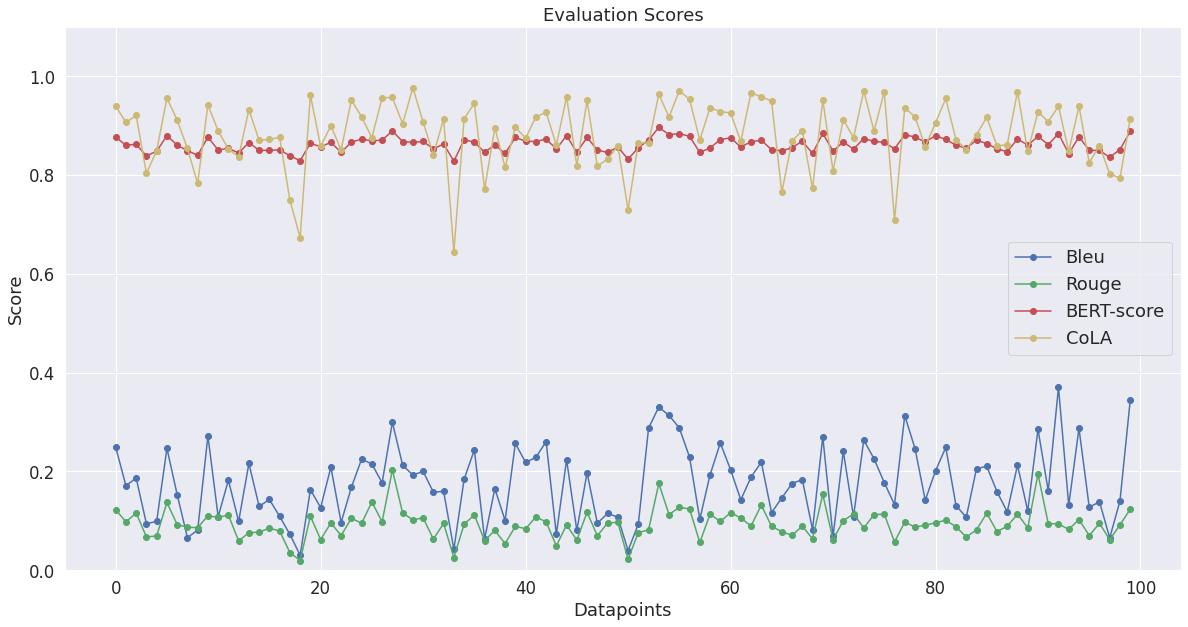

In [ ]:
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 2)



sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(results['bleu'], 'b-o', label="Bleu")
plt.plot(results['rouge'], 'g-o', label="Rouge")
plt.plot(results['bert_score'], 'r-o', label="BERT-score")
plt.plot(results['cola'], 'y-o', label="CoLA")
plt.ylim([0, 1.1])

plt.title("Evaluation Scores")
plt.xlabel("Datapoints")
plt.ylabel("Score")
plt.legend(fontsize=18)
#xt = [i for i in range(1,epochs+1)]
#plt.xticks(xt)

plt.show()

In [ ]:
import numpy as np

In [ ]:
total = []
for i in range(len(results)):
  total.append((results['bleu'][i] + results['rouge'][i] + results['bert_score'][i] + results['cola'][i])/4)

In [ ]:
test_data['keywords'][np.argmin(total)]

'gut, obscure, likely, fundamental, mathematical'

In [ ]:
Economist Cover Letter keywords: gut, obscure, likely

In [ ]:
total[np.argmin(total)]

0.591350708829843

In [ ]:
len(results['generated_text'][np.argmin(total)].split())

54

In [ ]:
np.mean(results['bleu']), np.mean(results['rouge']), np.mean(results['bert_score']), np.mean(results['cola'])

(0.156373636374139, 0.09084701844166393, 0.8548134775500639, 0.864579969527473)

In [ ]:
#version 1 _lr34_b4_e5 (0.17519533640160592, 0.09316142861025796, 0.8613857206712683, 0.8830849335080146)
#version 2 _lr44_b4_e7 (0.1658678309819539, 0.09056781118299789, 0.8590740893658803, 0.8623769607778917)
#version 3 _lr14_b4_e6 (0.156373636374139, 0.09084701844166393, 0.8548134775500639, 0.864579969527473)

In [ ]:
[round(i,3) for i in [0.156373636374139, 0.09084701844166393, 0.8548134775500639, 0.864579969527473]]

[0.156, 0.091, 0.855, 0.865]

# jonasmue/cover-letter-gpt2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 596 kB 80.2 MB/s 
     |████████████████████████████████| 6.6 MB 59.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')


tokenizer.encode("Sample Text")

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

[36674, 8255]

In [ ]:
import random
try:
  from transformers import GPT2LMHeadModel, GPT2Config
except:
  !pip install transformers
  from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np
import torch

In [ ]:
#model = GPT2LMHeadModel(configuration)
model = GPT2LMHeadModel.from_pretrained('jonasmue/cover-letter-gpt2')#, config=configuration)
#nouamanetazi/cover-letter-gpt2
#jonasmue/cover-letter-gpt2
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
max_text = 677

In [ ]:
model.eval()

prompt = "Cover Letter AI "

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = max_text,
                                temperature=0.7,
                                top_p=0.95, 
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}:{}\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:Cover Letter AI  (111) 789-3456
jason.myers@email.com
August 21, 2019
Dear Hiring Manager,
I'm excited to apply for the Intern position at Cloud Clearwater. I feel like I would be a great fit for this position and I'm excited to be able to bring my experience and passion for the technology field to Cloud Clearwater.
I am a skilled software developer with eight years of experience working in the software industry. I have a Bachelor’s degree in Computer Science. I have worked in the software industry for a decade. I have worked in a software-based environment. I have a Master’s degree in Computer Science. I have also worked in the software industry for a long time. I have worked on a wide variety of projects including C++ programs and C#. I have worked on a large scale. I have also worked on a large scale in other industries. I have been able to work on a small scale. I have also worked on a large scale in other industries.
I have worked on a large scale in other industries. I have wor